In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 2
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 3e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
perceptual_ext = PerceptualLoss()

In [15]:
sobel_filter = Sobel().to(device)

In [16]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)
    
    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    edge_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        edge_x = sobel_filter(x)
        
        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()
        
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr.detach(), edge_y_pr.detach()), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.zeros(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        # Perceptual loss
        perceptual_loss = perceptual_ext(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())
        
        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + air_loss + bone_loss + perceptual_loss + _mae 
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _dis.item()
        gen_l += _gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        mae_l += _mae.item()
        perceptual_l += perceptual_loss.item()
        
    return  perceptual_l/(index+1), mae_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [17]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    edge_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        edge_x = sobel_filter(x)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.zeros(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.ones(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [18]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [19]:
from codes.activation import Activation
import torchvision.models as models

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = models.resnet18()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=512, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Generator

In [21]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [22]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [23]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [24]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [25]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [26]:
len(trainset), len(testset)

(1344, 191)

In [27]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f9c13615ee0>,)

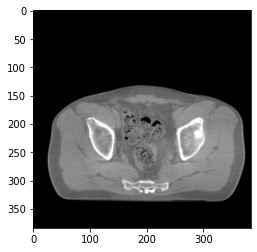

In [28]:
plt.imshow(x.squeeze(), 'gray'),

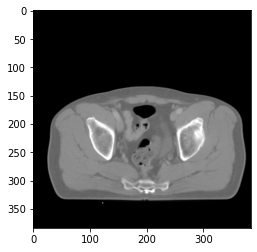

In [29]:
plt.imshow(y.squeeze(), 'gray')

In [30]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [31]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = Generator(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 attention_type=DECODER_ATT)

In [34]:
discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [35]:
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
replace_relu_to_leakyReLU(discriminator)

In [36]:
model

Generator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slo

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [38]:
wandb.watch(model)
wandb.watch(discriminator)

min_acc = 2

for epoch in range(EPOCH):
        
        loss_perceptual, loss_mae, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        wandb.log({
            "loss mae": loss_mae,
            "loss perceptual": loss_perceptual,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_acc_test <= min_acc:
            min_acc = score_acc_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [03:05,  1.10s/it]
168it [00:44,  3.79it/s]
24it [00:06,  3.60it/s]
168it [03:22,  1.21s/it]
168it [00:59,  2.84it/s]
24it [00:08,  2.70it/s]
168it [03:35,  1.28s/it]
168it [00:56,  2.98it/s]
24it [00:08,  2.94it/s]
168it [03:35,  1.28s/it]
168it [00:56,  2.99it/s]
24it [00:08,  2.81it/s]
168it [03:35,  1.28s/it]
168it [00:58,  2.86it/s]
24it [00:08,  2.77it/s]
168it [03:36,  1.29s/it]
168it [00:58,  2.87it/s]
24it [00:08,  2.82it/s]
168it [03:36,  1.29s/it]
168it [01:02,  2.68it/s]
24it [00:08,  2.72it/s]
168it [03:38,  1.30s/it]
168it [01:01,  2.74it/s]
24it [00:08,  2.76it/s]
168it [03:38,  1.30s/it]
168it [01:00,  2.78it/s]
24it [00:08,  2.92it/s]
168it [03:39,  1.31s/it]
168it [01:03,  2.65it/s]
24it [00:08,  2.76it/s]
168it [03:41,  1.32s/it]
168it [00:52,  3.17it/s]
24it [00:12,  1.85it/s]
168it [03:43,  1.33s/it]
168it [00:53,  3.16it/s]
24it [00:07,  3.05it/s]
168it [03:41,  1.32s/it]
168it [00:53,  3.14it/s]
24it [00:09,  2.45it/s]
168it [03:41,  1.32s/it]
168it [00:53,

In [39]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [40]:
model = Generator(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [41]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8369454741477966
psnr score = 20.694499969482422
snr score = 10.757436752319336
mae error = 0.03350502997636795
air dice score = 0.9837420121860765
bone dice score = 2.9036004644917653e-11
contour dice score = 0.06170598790049553


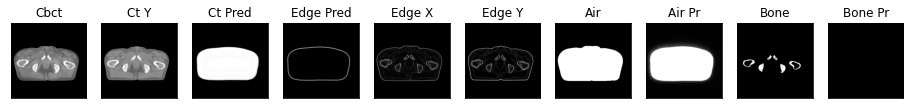

1it [00:00,  1.97it/s]

ssim score = 0.837813138961792
psnr score = 20.67913818359375
snr score = 10.789609909057617
mae error = 0.03349386528134346
air dice score = 0.9841031170552839
bone dice score = 2.8868360276302878e-11
contour dice score = 0.06310679763555527


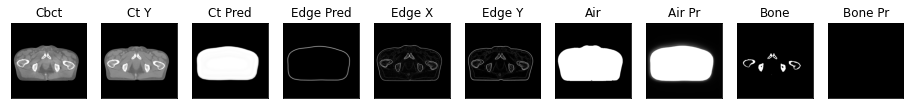

2it [00:01,  1.88it/s]

ssim score = 0.8306034803390503
psnr score = 20.27289390563965
snr score = 10.5462646484375
mae error = 0.03517414629459381
air dice score = 0.9843380526946026
bone dice score = 2.3963575364870272e-11
contour dice score = 0.07537993788719177


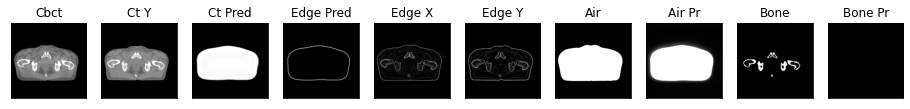

3it [00:01,  1.64it/s]

ssim score = 0.824630618095398
psnr score = 20.07278060913086
snr score = 10.435403823852539
mae error = 0.03635614737868309
air dice score = 0.9852298731017413
bone dice score = 2.1473051320131565e-11
contour dice score = 0.04747413098812103


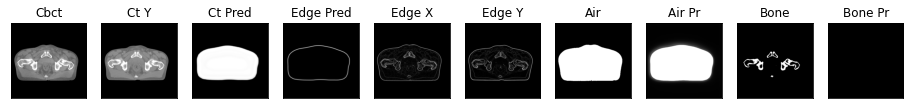

4it [00:02,  1.50it/s]

ssim score = 0.819823682308197
psnr score = 20.06160545349121
snr score = 10.464529037475586
mae error = 0.03713560849428177
air dice score = 0.9853918980608684
bone dice score = 1.9286403085452526e-11
contour dice score = 0.07181984186172485


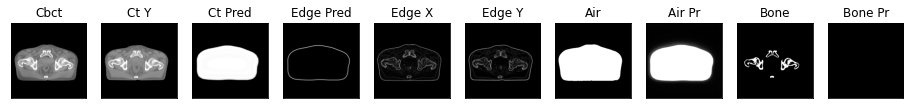

5it [00:03,  1.55it/s]

ssim score = 0.8182344436645508
psnr score = 19.76207160949707
snr score = 10.301530838012695
mae error = 0.03925415500998497
air dice score = 0.9857531742404815
bone dice score = 1.6329196603260463e-11
contour dice score = 0.08929663896560669


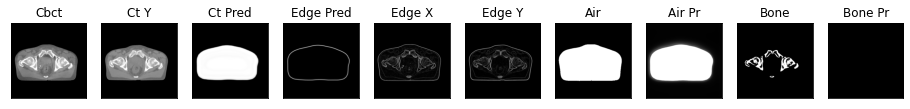

6it [00:03,  1.66it/s]

ssim score = 0.8235378265380859
psnr score = 19.843936920166016
snr score = 10.359338760375977
mae error = 0.03864403814077377
air dice score = 0.985250560957382
bone dice score = 1.563966218305224e-11
contour dice score = 0.09459459781646729


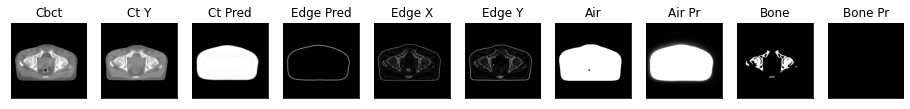

7it [00:04,  1.58it/s]

ssim score = 0.83118736743927
psnr score = 20.164569854736328
snr score = 10.494438171386719
mae error = 0.03616274893283844
air dice score = 0.9862801660451838
bone dice score = 1.7394329448297195e-11
contour dice score = 0.1344848871231079


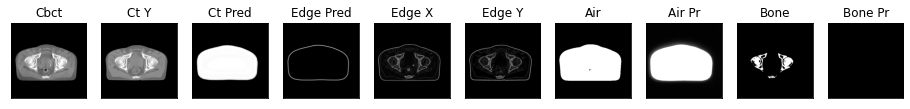

8it [00:04,  1.78it/s]

ssim score = 0.8358930349349976
psnr score = 20.302757263183594
snr score = 10.538070678710938
mae error = 0.03501445800065994
air dice score = 0.9863002618621672
bone dice score = 1.898974553704919e-11
contour dice score = 0.12879256904125214


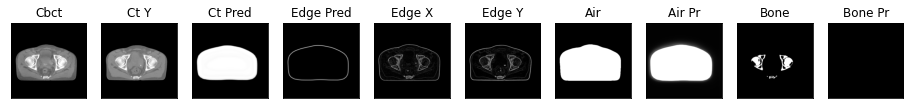

9it [00:05,  1.89it/s]

ssim score = 0.8427833914756775
psnr score = 20.366310119628906
snr score = 10.586337089538574
mae error = 0.034564271569252014
air dice score = 0.9844011991260765
bone dice score = 1.9920318724702783e-11
contour dice score = 0.1352357268333435


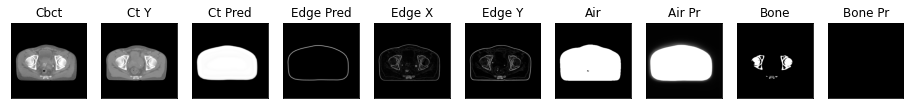

10it [00:05,  2.05it/s]

ssim score = 0.8475950360298157
psnr score = 20.212844848632812
snr score = 10.465143203735352
mae error = 0.03504519909620285
air dice score = 0.9844614707898315
bone dice score = 2.105706464474506e-11
contour dice score = 0.08706467598676682


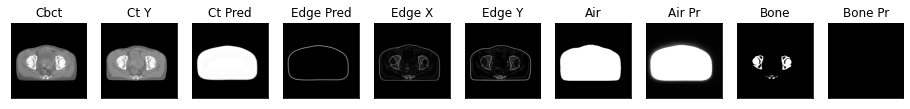

11it [00:06,  2.15it/s]

ssim score = 0.8553959727287292
psnr score = 20.177452087402344
snr score = 10.453458786010742
mae error = 0.03486020490527153
air dice score = 0.9802512727870132
bone dice score = 2.107481559491939e-11
contour dice score = 0.1354878842830658


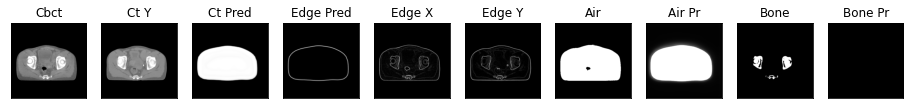

12it [00:06,  2.23it/s]

ssim score = 0.8561269044876099
psnr score = 20.103120803833008
snr score = 10.347204208374023
mae error = 0.03484001010656357
air dice score = 0.975049211076898
bone dice score = 2.2583559168415004e-11
contour dice score = 0.18373681604862213


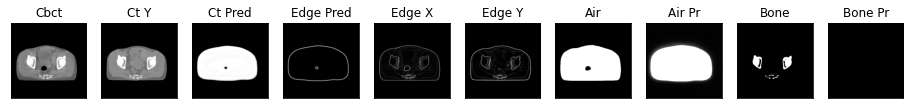

13it [00:06,  2.26it/s]

ssim score = 0.8491674661636353
psnr score = 20.504459381103516
snr score = 10.606588363647461
mae error = 0.03374367207288742
air dice score = 0.9745746868573829
bone dice score = 2.4467824809775684e-11
contour dice score = 0.15855181217193604


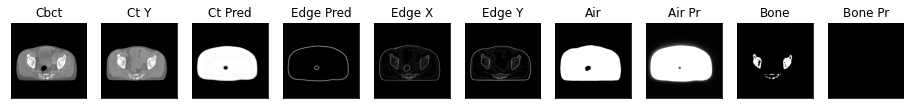

14it [00:07,  2.32it/s]

ssim score = 0.8424056172370911
psnr score = 20.511585235595703
snr score = 10.528050422668457
mae error = 0.033765342086553574
air dice score = 0.9731621449390709
bone dice score = 2.5920165888389833e-11
contour dice score = 0.13483145833015442


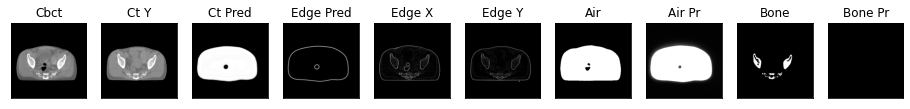

15it [00:07,  2.30it/s]

ssim score = 0.8392137289047241
psnr score = 20.409700393676758
snr score = 10.449652671813965
mae error = 0.03436805307865143
air dice score = 0.9776534543727475
bone dice score = 2.4770869456904362e-11
contour dice score = 0.12159594893455505


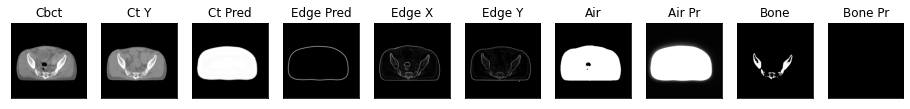

16it [00:08,  2.35it/s]

ssim score = 0.827061653137207
psnr score = 19.498668670654297
snr score = 9.536077499389648
mae error = 0.038142129778862
air dice score = 0.9734217856307824
bone dice score = 2.3441162681119523e-11
contour dice score = 0.13434727489948273


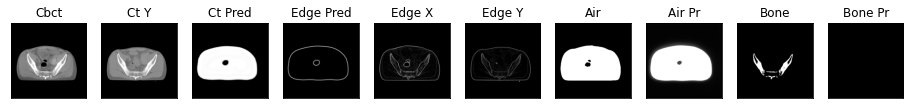

17it [00:08,  2.02it/s]

ssim score = 0.8226161599159241
psnr score = 19.22233009338379
snr score = 9.157976150512695
mae error = 0.039828717708587646
air dice score = 0.969841660689274
bone dice score = 2.364625206848791e-11
contour dice score = 0.11985018849372864


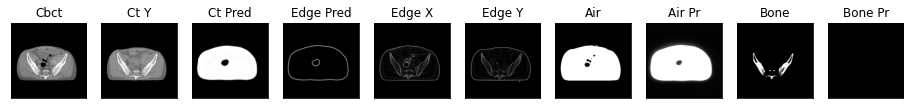

18it [00:09,  2.09it/s]

ssim score = 0.8154538869857788
psnr score = 18.962507247924805
snr score = 8.847472190856934
mae error = 0.04131745919585228
air dice score = 0.965406638825542
bone dice score = 2.3331777880930195e-11
contour dice score = 0.08974359184503555


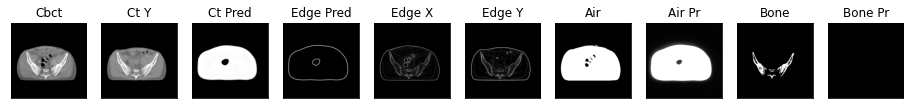

19it [00:09,  2.18it/s]

ssim score = 0.8187705874443054
psnr score = 19.3562068939209
snr score = 9.228860855102539
mae error = 0.03886650875210762
air dice score = 0.9727098904919469
bone dice score = 2.4113817216684018e-11
contour dice score = 0.07923322916030884


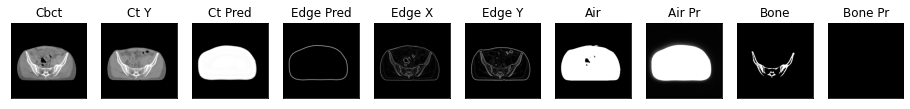

20it [00:10,  2.21it/s]

ssim score = 0.8164297342300415
psnr score = 19.271820068359375
snr score = 9.079628944396973
mae error = 0.03917389363050461
air dice score = 0.9727907589599737
bone dice score = 2.61780104705189e-11
contour dice score = 0.09800128638744354


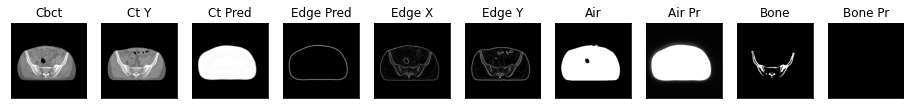

21it [00:10,  2.29it/s]

ssim score = 0.813129723072052
psnr score = 19.08414649963379
snr score = 8.832525253295898
mae error = 0.039946556091308594
air dice score = 0.9736382334078183
bone dice score = 2.585315408412996e-11
contour dice score = 0.10123296827077866


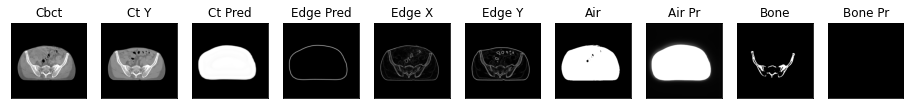

22it [00:11,  2.28it/s]

ssim score = 0.8141570687294006
psnr score = 18.926746368408203
snr score = 8.641697883605957
mae error = 0.040445998311042786
air dice score = 0.9743721569635819
bone dice score = 2.427184465960505e-11
contour dice score = 0.08610567450523376


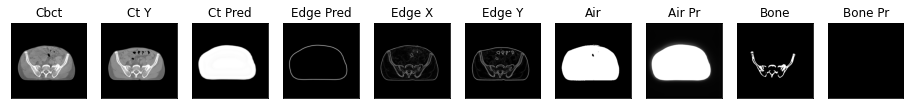

23it [00:11,  2.34it/s]

ssim score = 0.8123453855514526
psnr score = 18.768518447875977
snr score = 8.434905052185059
mae error = 0.041498713195323944
air dice score = 0.9738261242356847
bone dice score = 2.3337222869933788e-11
contour dice score = 0.0452127642929554


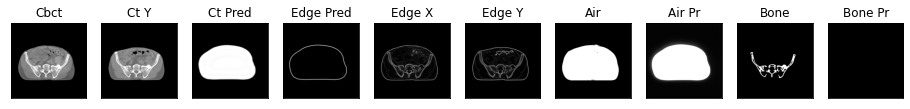

24it [00:11,  2.32it/s]

ssim score = 0.8080483078956604
psnr score = 18.6251220703125
snr score = 8.194509506225586
mae error = 0.042307812720537186
air dice score = 0.9717184208116106
bone dice score = 2.2416498542425095e-11
contour dice score = 0.03232323378324509


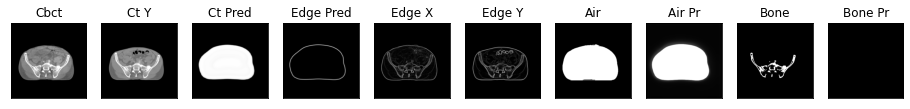

25it [00:12,  2.37it/s]

ssim score = 0.8090223670005798
psnr score = 18.607929229736328
snr score = 8.094582557678223
mae error = 0.04233121871948242
air dice score = 0.9692081769656078
bone dice score = 2.220248667801504e-11
contour dice score = 0.06530611962080002


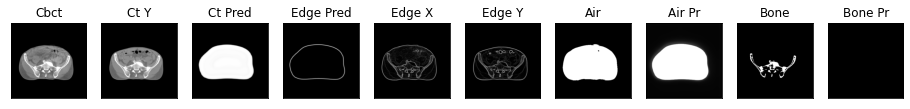

26it [00:12,  2.35it/s]

ssim score = 0.8094927072525024
psnr score = 18.42117691040039
snr score = 7.816641330718994
mae error = 0.04364947974681854
air dice score = 0.9638001017715776
bone dice score = 2.181025081740872e-11
contour dice score = 0.06527777761220932


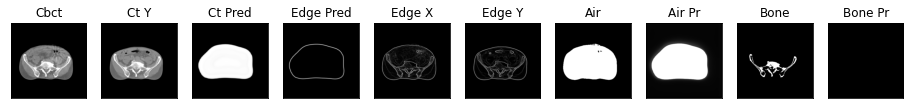

27it [00:13,  2.07it/s]

ssim score = 0.8110507130622864
psnr score = 18.40141487121582
snr score = 7.7557759284973145
mae error = 0.04367061331868172
air dice score = 0.9601446671936479
bone dice score = 2.0768431982953927e-11
contour dice score = 0.09677419066429138


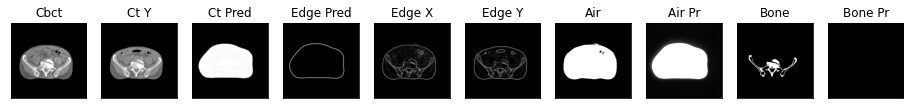

28it [00:13,  2.14it/s]

ssim score = 0.7383242845535278
psnr score = 15.810043334960938
snr score = 7.1822004318237305
mae error = 0.07925132662057877
air dice score = 0.970291296356926
bone dice score = 6.36132315481162e-11
contour dice score = 0.11177828907966614


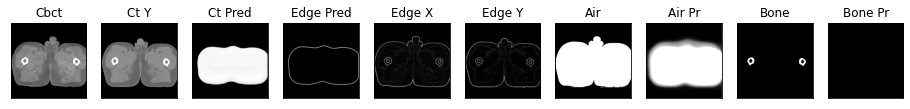

29it [00:14,  2.23it/s]

ssim score = 0.7363079786300659
psnr score = 15.71856689453125
snr score = 7.129981994628906
mae error = 0.08088817447423935
air dice score = 0.9671556162393261
bone dice score = 5.934718100537998e-11
contour dice score = 0.1125226840376854


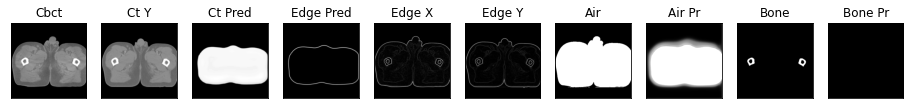

30it [00:14,  2.26it/s]

ssim score = 0.731550931930542
psnr score = 15.620060920715332
snr score = 7.118926048278809
mae error = 0.08279595524072647
air dice score = 0.9569495694957221
bone dice score = 4.67508181371318e-11
contour dice score = 0.1147463247179985


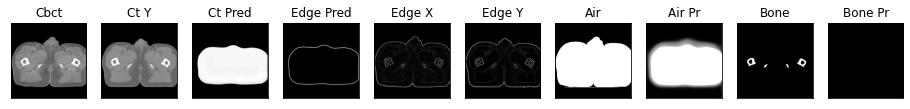

31it [00:14,  2.31it/s]

ssim score = 0.721546471118927
psnr score = 15.489892959594727
snr score = 7.151313304901123
mae error = 0.08510098606348038
air dice score = 0.9513427380854829
bone dice score = 3.1867431484006776e-11
contour dice score = 0.11448141187429428


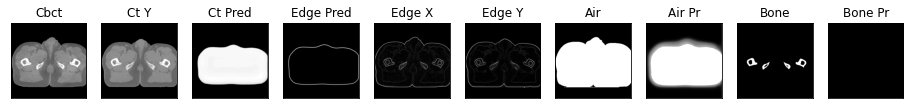

32it [00:15,  2.37it/s]

ssim score = 0.7099591493606567
psnr score = 15.455435752868652
snr score = 7.244999408721924
mae error = 0.08591766655445099
air dice score = 0.9486703303645072
bone dice score = 2.7555800495245087e-11
contour dice score = 0.1124260351061821


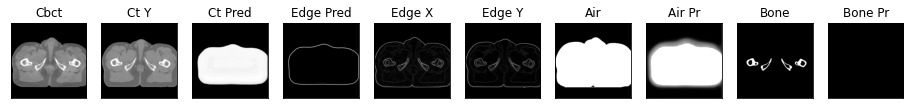

33it [00:15,  2.40it/s]

ssim score = 0.7059542536735535
psnr score = 15.454904556274414
snr score = 7.3477067947387695
mae error = 0.08629366010427475
air dice score = 0.9521760403467914
bone dice score = 2.3986567521612218e-11
contour dice score = 0.10385756939649582


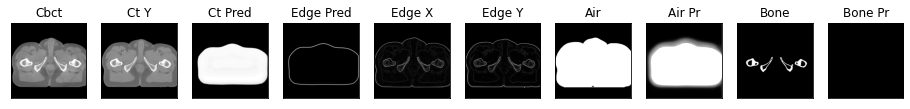

34it [00:16,  2.37it/s]

ssim score = 0.7024112343788147
psnr score = 15.410341262817383
snr score = 7.370244979858398
mae error = 0.0875731036067009
air dice score = 0.9591915231525391
bone dice score = 2.1953896816202988e-11
contour dice score = 0.1040118858218193


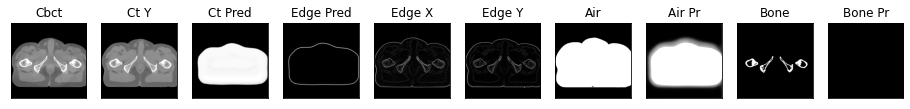

35it [00:16,  2.40it/s]

ssim score = 0.6971398591995239
psnr score = 15.38667106628418
snr score = 7.33668327331543
mae error = 0.08796638995409012
air dice score = 0.9634379196077932
bone dice score = 2.0733982997704042e-11
contour dice score = 0.07319485396146774


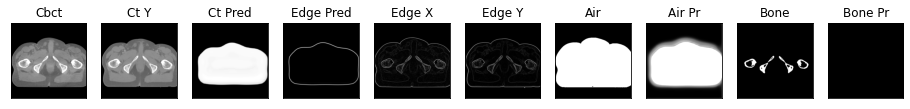

36it [00:17,  2.36it/s]

ssim score = 0.6974257826805115
psnr score = 15.339496612548828
snr score = 7.275843620300293
mae error = 0.08795511722564697
air dice score = 0.9571012232927072
bone dice score = 2.052966536603306e-11
contour dice score = 0.09500247240066528


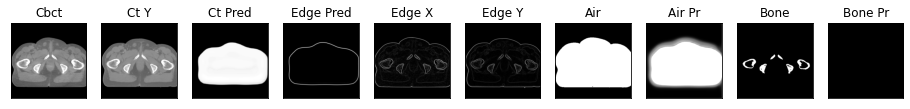

37it [00:17,  2.03it/s]

ssim score = 0.6996579766273499
psnr score = 15.314327239990234
snr score = 7.2626776695251465
mae error = 0.08840300142765045
air dice score = 0.9565389467435399
bone dice score = 2.170609941346416e-11
contour dice score = 0.08142998814582825


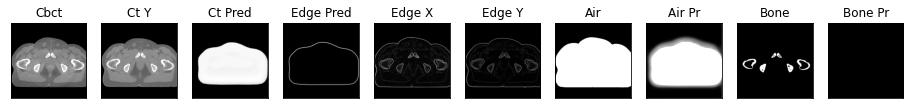

38it [00:18,  2.15it/s]

ssim score = 0.6949477791786194
psnr score = 15.29813289642334
snr score = 7.285566806793213
mae error = 0.08834751695394516
air dice score = 0.9578487295355471
bone dice score = 2.2311468094102822e-11
contour dice score = 0.07470119744539261


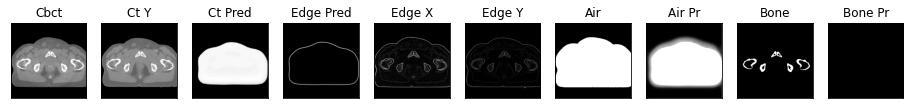

39it [00:18,  2.23it/s]

ssim score = 0.6850999593734741
psnr score = 15.12330436706543
snr score = 7.25202751159668
mae error = 0.09068041294813156
air dice score = 0.9659475711390412
bone dice score = 1.901140684374503e-11
contour dice score = 4.99001985565517e-11


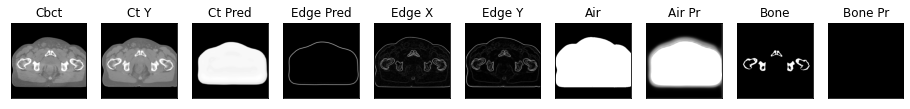

40it [00:18,  2.30it/s]

ssim score = 0.6711936593055725
psnr score = 14.897401809692383
snr score = 7.120810508728027
mae error = 0.09432455152273178
air dice score = 0.9587923800814644
bone dice score = 1.5703517587693097e-11
contour dice score = 5.00000006675716e-11


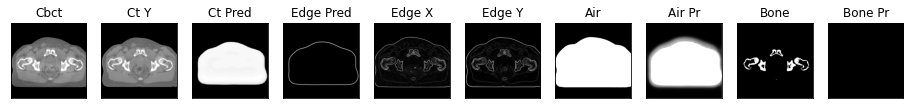

41it [00:19,  2.32it/s]

ssim score = 0.6552345752716064
psnr score = 14.62589168548584
snr score = 6.815256118774414
mae error = 0.09906265884637833
air dice score = 0.9776076787558607
bone dice score = 1.520450053192634e-11
contour dice score = 0.064635269343853


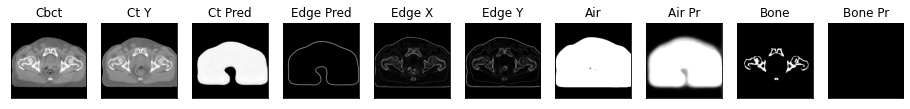

42it [00:19,  2.33it/s]

ssim score = 0.6531458497047424
psnr score = 14.547016143798828
snr score = 6.808566093444824
mae error = 0.10097796469926834
air dice score = 0.9785200536389257
bone dice score = 1.2884937507887064e-11
contour dice score = 0.10919017344713211


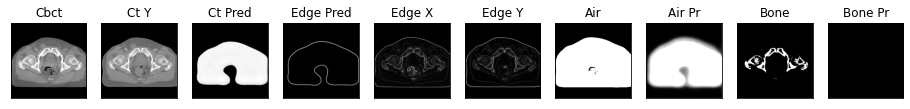

43it [00:20,  2.38it/s]

ssim score = 0.6634730100631714
psnr score = 14.942130088806152
snr score = 7.067584991455078
mae error = 0.09444345533847809
air dice score = 0.9812167634288059
bone dice score = 1.669727834335119e-11
contour dice score = 0.11320754885673523


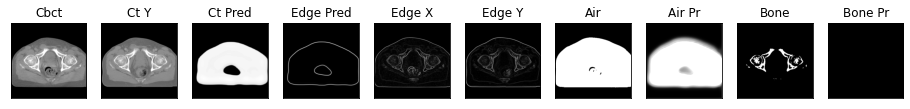

44it [00:20,  2.37it/s]

ssim score = 0.6735658049583435
psnr score = 15.17519474029541
snr score = 7.122088432312012
mae error = 0.09036310017108917
air dice score = 0.9640764426400209
bone dice score = 1.8821757951838475e-11
contour dice score = 0.10578842461109161


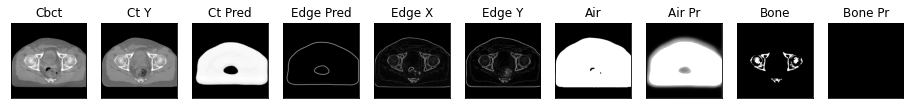

45it [00:21,  2.40it/s]

ssim score = 0.6840010285377502
psnr score = 15.297451972961426
snr score = 7.153757095336914
mae error = 0.08910976350307465
air dice score = 0.9681649222646501
bone dice score = 2.1294718909256925e-11
contour dice score = 0.08682483434677124


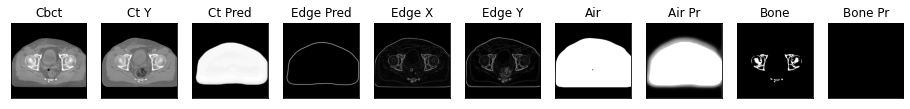

46it [00:21,  2.39it/s]

ssim score = 0.6932485699653625
psnr score = 15.202012062072754
snr score = 7.074008464813232
mae error = 0.09055895358324051
air dice score = 0.9800548676503422
bone dice score = 1.983339944427145e-11
contour dice score = 0.07797468453645706


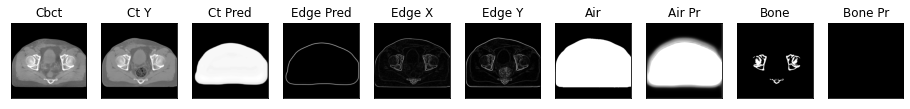

47it [00:22,  2.00it/s]

ssim score = 0.700432538986206
psnr score = 15.230720520019531
snr score = 7.112751483917236
mae error = 0.08986270427703857
air dice score = 0.982296064278916
bone dice score = 1.7966223499497554e-11
contour dice score = 0.07785642147064209


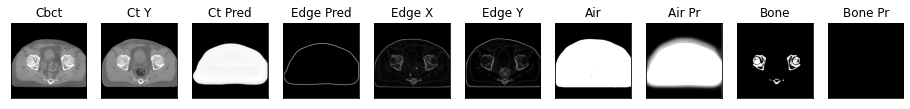

48it [00:22,  2.08it/s]

ssim score = 0.7065821886062622
psnr score = 15.13206672668457
snr score = 7.075687408447266
mae error = 0.08989488333463669
air dice score = 0.9841884518787137
bone dice score = 1.7488632388641332e-11
contour dice score = 0.09864116460084915


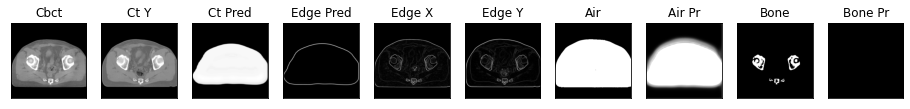

49it [00:22,  2.16it/s]

ssim score = 0.7114629745483398
psnr score = 15.031167984008789
snr score = 7.044870853424072
mae error = 0.09052247554063797
air dice score = 0.9846552065788265
bone dice score = 1.7155601303531385e-11
contour dice score = 0.09246230870485306


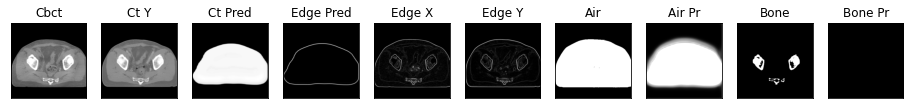

50it [00:23,  2.25it/s]

ssim score = 0.7049926519393921
psnr score = 15.235472679138184
snr score = 7.130069732666016
mae error = 0.08846510946750641
air dice score = 0.9881364493119706
bone dice score = 1.8978933383583622e-11
contour dice score = 0.09313970804214478


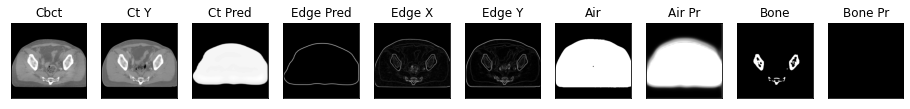

51it [00:23,  2.28it/s]

ssim score = 0.695793867111206
psnr score = 15.113371849060059
snr score = 7.089595794677734
mae error = 0.09145641326904297
air dice score = 0.9902018637358374
bone dice score = 1.6531658125036674e-11
contour dice score = 0.1003512293100357


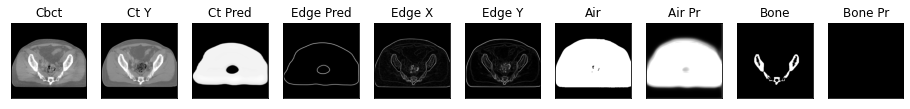

52it [00:24,  2.34it/s]

ssim score = 0.6843085885047913
psnr score = 14.990097045898438
snr score = 7.046469688415527
mae error = 0.09344235807657242
air dice score = 0.9828094059406047
bone dice score = 1.3825521913261087e-11
contour dice score = 0.08241205662488937


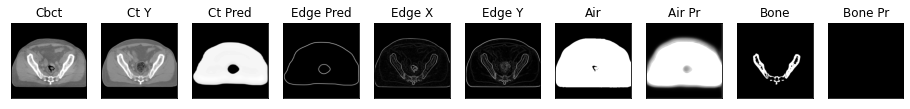

53it [00:24,  2.37it/s]

ssim score = 0.6703157424926758
psnr score = 14.824928283691406
snr score = 6.902857303619385
mae error = 0.09619612991809845
air dice score = 0.9728301510544065
bone dice score = 1.3865779256601972e-11
contour dice score = 0.07606490701436996


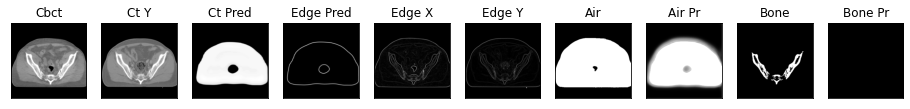

54it [00:25,  2.31it/s]

ssim score = 0.6684809327125549
psnr score = 14.701432228088379
snr score = 6.79189920425415
mae error = 0.09639251977205276
air dice score = 0.9775805784741602
bone dice score = 1.4076576576378426e-11
contour dice score = 0.06826286017894745


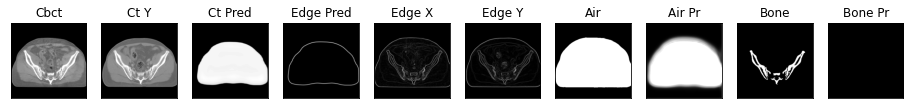

55it [00:25,  2.38it/s]

ssim score = 0.8306598663330078
psnr score = 19.926374435424805
snr score = 9.8065824508667
mae error = 0.03807557001709938
air dice score = 0.9718162839248692
bone dice score = 5.464480874018334e-11
contour dice score = 0.032898467034101486


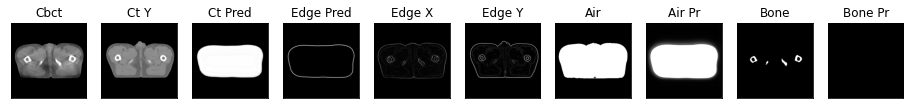

56it [00:25,  2.43it/s]

ssim score = 0.8238635063171387
psnr score = 19.48573875427246
snr score = 9.57892894744873
mae error = 0.040559131652116776
air dice score = 0.971590494934059
bone dice score = 4.361098996757039e-11
contour dice score = 0.020361991599202156


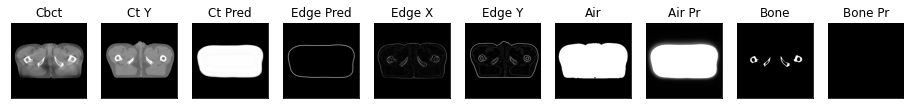

57it [00:26,  2.02it/s]

ssim score = 0.8174253702163696
psnr score = 19.326393127441406
snr score = 9.550722122192383
mae error = 0.04175533726811409
air dice score = 0.9719238502364085
bone dice score = 4.0933278753952794e-11
contour dice score = 0.021444695070385933


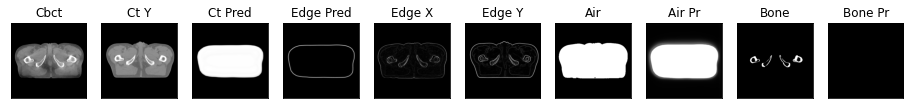

58it [00:26,  2.08it/s]

ssim score = 0.8127333521842957
psnr score = 19.299652099609375
snr score = 9.594382286071777
mae error = 0.04252608120441437
air dice score = 0.9718171582977061
bone dice score = 3.9651070577333427e-11
contour dice score = 0.009014084935188293


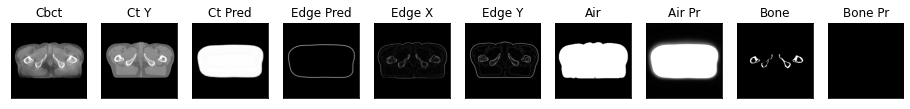

59it [00:27,  2.19it/s]

ssim score = 0.8083301782608032
psnr score = 19.283157348632812
snr score = 9.62545108795166
mae error = 0.04296860471367836
air dice score = 0.9724644044408451
bone dice score = 3.8197097019167415e-11
contour dice score = 0.016853932291269302


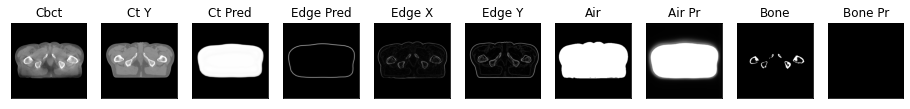

60it [00:27,  2.25it/s]

ssim score = 0.8054798245429993
psnr score = 19.259145736694336
snr score = 9.607059478759766
mae error = 0.043137457221746445
air dice score = 0.9728635508351634
bone dice score = 3.716090672474318e-11
contour dice score = 0.01971522532403469


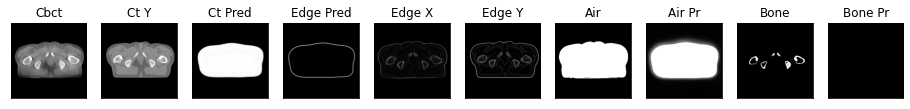

61it [00:28,  2.32it/s]

ssim score = 0.8015410900115967
psnr score = 19.237682342529297
snr score = 9.579092025756836
mae error = 0.04307989403605461
air dice score = 0.975442887654113
bone dice score = 3.775009437381087e-11
contour dice score = 0.018681319430470467


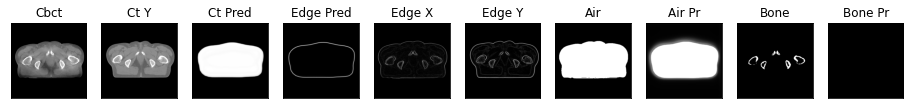

62it [00:28,  2.27it/s]

ssim score = 0.8000662922859192
psnr score = 19.200519561767578
snr score = 9.556039810180664
mae error = 0.04291294887661934
air dice score = 0.9767261374560348
bone dice score = 3.6968576708429996e-11
contour dice score = 0.019747668877243996


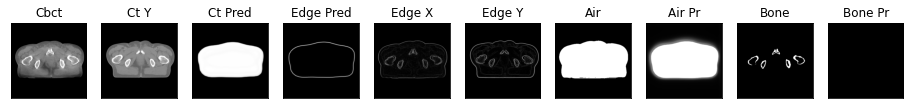

63it [00:29,  2.34it/s]

ssim score = 0.7960683703422546
psnr score = 19.021413803100586
snr score = 9.43493938446045
mae error = 0.04357123374938965
air dice score = 0.9767257479122091
bone dice score = 3.2733224221514463e-11
contour dice score = 0.019856590777635574


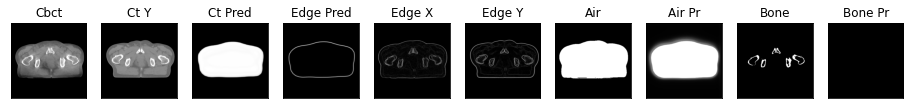

64it [00:29,  2.29it/s]

ssim score = 0.7896305322647095
psnr score = 18.750652313232422
snr score = 9.262739181518555
mae error = 0.04541149362921715
air dice score = 0.9776205855508165
bone dice score = 3.072196620489333e-11
contour dice score = 0.008728859946131706


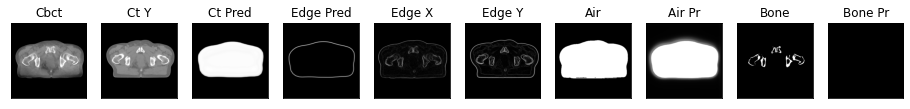

65it [00:29,  2.35it/s]

ssim score = 0.7835232019424438
psnr score = 18.71338653564453
snr score = 9.261302947998047
mae error = 0.04608786478638649
air dice score = 0.9815720653014574
bone dice score = 2.928257686590681e-11
contour dice score = 0.011092623695731163


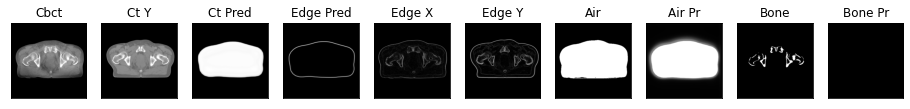

66it [00:30,  2.32it/s]

ssim score = 0.7769873142242432
psnr score = 18.712173461914062
snr score = 9.292795181274414
mae error = 0.0468856617808342
air dice score = 0.9814349106077801
bone dice score = 2.594706798064486e-11
contour dice score = 5.52486181804035e-11


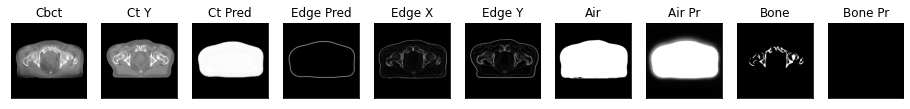

67it [00:31,  1.99it/s]

ssim score = 0.7714277505874634
psnr score = 18.45800018310547
snr score = 9.155439376831055
mae error = 0.04949719458818436
air dice score = 0.9818100543291539
bone dice score = 2.5980774226396966e-11
contour dice score = 0.006539509631693363


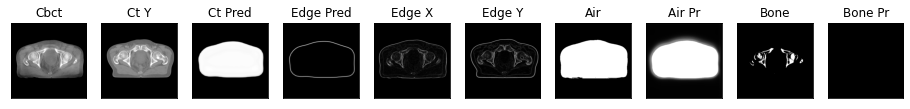

68it [00:31,  2.11it/s]

ssim score = 0.7704207897186279
psnr score = 18.39361000061035
snr score = 9.07506275177002
mae error = 0.049775395542383194
air dice score = 0.9790391327989519
bone dice score = 2.884338044335612e-11
contour dice score = 0.006764374207705259


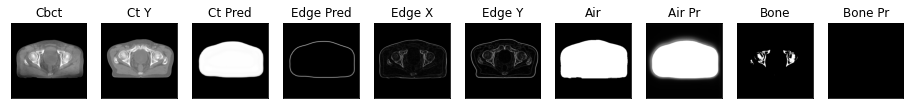

69it [00:31,  2.20it/s]

ssim score = 0.7803351283073425
psnr score = 18.71253776550293
snr score = 9.194826126098633
mae error = 0.04645862057805061
air dice score = 0.9712729555522407
bone dice score = 3.108486167139929e-11
contour dice score = 0.0044469148851931095


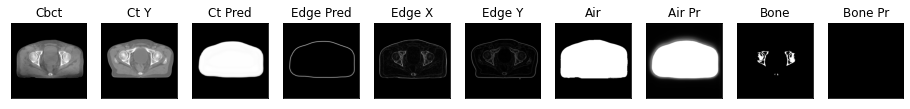

70it [00:32,  2.21it/s]

ssim score = 0.7937815189361572
psnr score = 19.087024688720703
snr score = 9.398921966552734
mae error = 0.043744735419750214
air dice score = 0.9679721604845635
bone dice score = 2.8546959747971826e-11
contour dice score = 0.0011154490057379007


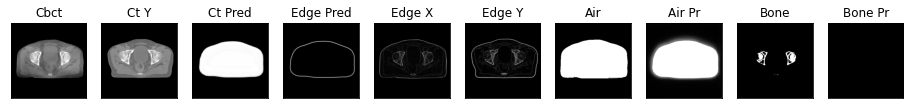

71it [00:32,  2.28it/s]

ssim score = 0.7985352277755737
psnr score = 19.08870506286621
snr score = 9.41476821899414
mae error = 0.044002335518598557
air dice score = 0.9656058176922632
bone dice score = 2.639915522633582e-11
contour dice score = 5.52486181804035e-11


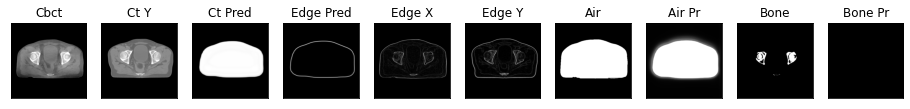

72it [00:33,  2.28it/s]

ssim score = 0.8008931279182434
psnr score = 18.89156723022461
snr score = 9.299460411071777
mae error = 0.04493305832147598
air dice score = 0.9634413174236507
bone dice score = 2.6759432699310692e-11
contour dice score = 5.6179776108944424e-11


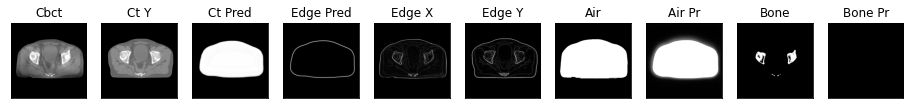

73it [00:33,  2.32it/s]

ssim score = 0.8032059073448181
psnr score = 18.68506622314453
snr score = 9.185132026672363
mae error = 0.04543793201446533
air dice score = 0.9629119058349789
bone dice score = 3.0321406912361387e-11
contour dice score = 5.704506658710251e-11


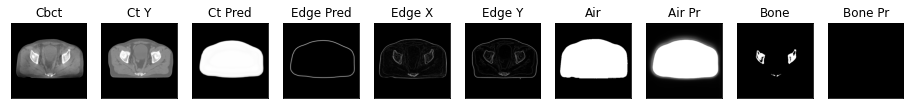

74it [00:34,  2.30it/s]

ssim score = 0.8023475408554077
psnr score = 19.08970069885254
snr score = 9.526339530944824
mae error = 0.04384272173047066
air dice score = 0.9631729541753197
bone dice score = 3.331112591494633e-11
contour dice score = 5.558643823011522e-11


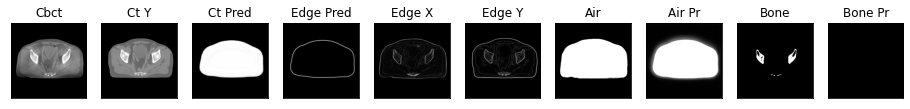

75it [00:34,  2.33it/s]

ssim score = 0.7976036071777344
psnr score = 18.96258544921875
snr score = 9.36282730102539
mae error = 0.04447687417268753
air dice score = 0.9587329008602817
bone dice score = 3.593244699834953e-11
contour dice score = 5.506608016792036e-11


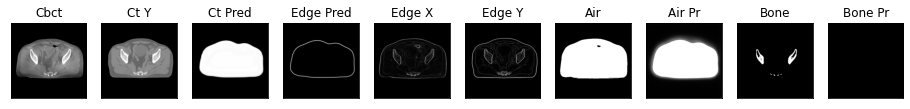

76it [00:34,  2.38it/s]

ssim score = 0.7883725762367249
psnr score = 18.851587295532227
snr score = 9.28957748413086
mae error = 0.045755431056022644
air dice score = 0.9577584002680699
bone dice score = 3.291639236231348e-11
contour dice score = 0.006571741309016943


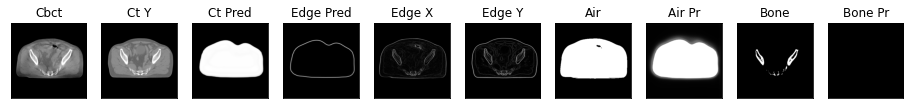

77it [00:35,  2.05it/s]

ssim score = 0.7793715000152588
psnr score = 18.748580932617188
snr score = 9.317076683044434
mae error = 0.046891480684280396
air dice score = 0.9632415617283732
bone dice score = 2.8481913983808548e-11
contour dice score = 5.518763918077596e-11


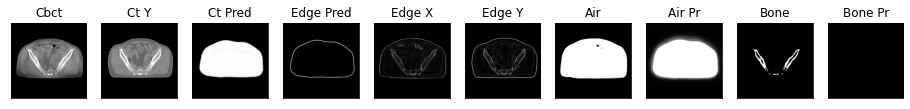

78it [00:35,  2.16it/s]

ssim score = 0.7739307880401611
psnr score = 18.690711975097656
snr score = 9.276954650878906
mae error = 0.048039574176073074
air dice score = 0.9623730908449172
bone dice score = 3.067484662482593e-11
contour dice score = 5.549389767156576e-11


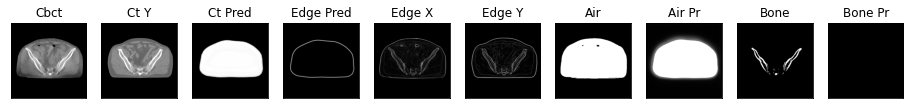

79it [00:36,  2.24it/s]

ssim score = 0.7725498080253601
psnr score = 18.771503448486328
snr score = 9.346480369567871
mae error = 0.04786285385489464
air dice score = 0.9653676203632677
bone dice score = 3.379520108030432e-11
contour dice score = 5.580357356760324e-11


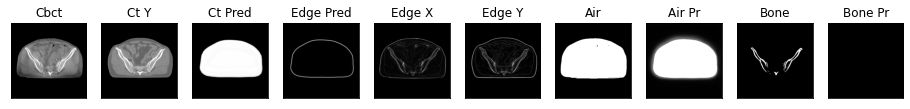

80it [00:36,  2.31it/s]

ssim score = 0.7715625166893005
psnr score = 18.730669021606445
snr score = 9.304903030395508
mae error = 0.04771795496344566
air dice score = 0.9674997337498957
bone dice score = 3.257328990121911e-11
contour dice score = 5.624296861572731e-11


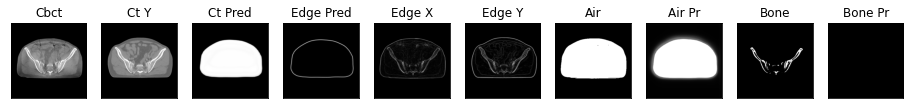

81it [00:37,  2.33it/s]

ssim score = 0.782259464263916
psnr score = 17.964601516723633
snr score = 8.398735046386719
mae error = 0.05191045254468918
air dice score = 0.9463160800783497
bone dice score = 7.745933384372894e-11
contour dice score = 0.004410143475979567


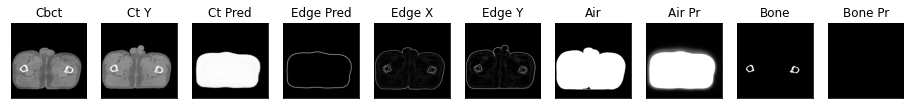

82it [00:37,  2.30it/s]

ssim score = 0.7767004370689392
psnr score = 17.939281463623047
snr score = 8.437808990478516
mae error = 0.052351225167512894
air dice score = 0.9457890446962208
bone dice score = 7.102272726768303e-11
contour dice score = 0.0043668122962117195


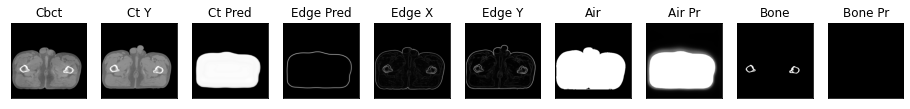

83it [00:37,  2.34it/s]

ssim score = 0.7728430032730103
psnr score = 17.94969367980957
snr score = 8.587430953979492
mae error = 0.052868179976940155
air dice score = 0.9531048446353435
bone dice score = 4.5372050814638294e-11
contour dice score = 0.005361930467188358


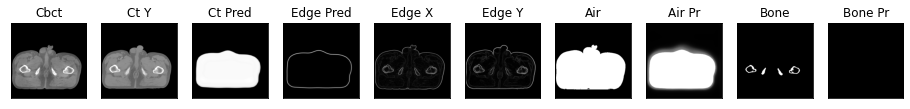

84it [00:38,  2.36it/s]

ssim score = 0.7708482146263123
psnr score = 17.980144500732422
snr score = 8.739374160766602
mae error = 0.05294637382030487
air dice score = 0.9678642267579757
bone dice score = 4.3668122268835455e-11
contour dice score = 0.004333694465458393


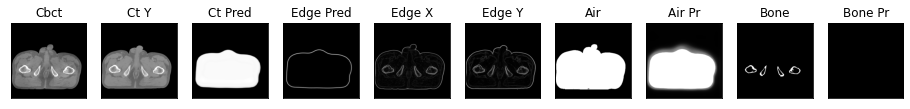

85it [00:38,  2.34it/s]

ssim score = 0.7675430178642273
psnr score = 18.13184928894043
snr score = 8.915253639221191
mae error = 0.05227549374103546
air dice score = 0.9750447326334655
bone dice score = 4.504504504301599e-11
contour dice score = 0.006525285542011261


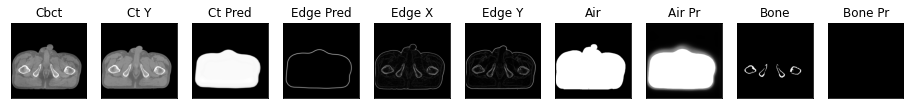

86it [00:39,  2.39it/s]

ssim score = 0.7669726610183716
psnr score = 18.255434036254883
snr score = 9.034440994262695
mae error = 0.05179041624069214
air dice score = 0.9784375492203666
bone dice score = 4.1101520754578645e-11
contour dice score = 5.452562706897979e-11


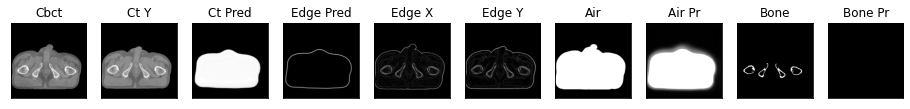

87it [00:39,  2.04it/s]

ssim score = 0.7694147229194641
psnr score = 18.27968406677246
snr score = 9.064945220947266
mae error = 0.051517803221940994
air dice score = 0.9806955243026918
bone dice score = 3.980891719586748e-11
contour dice score = 5.479451961609705e-11


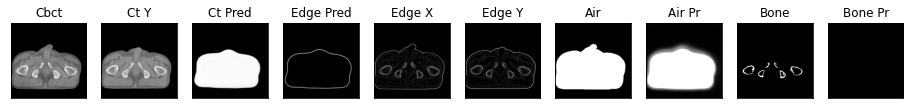

88it [00:40,  2.10it/s]

ssim score = 0.7716885209083557
psnr score = 18.444835662841797
snr score = 9.208541870117188
mae error = 0.0497673936188221
air dice score = 0.9820465805797355
bone dice score = 3.958828186699967e-11
contour dice score = 0.0272479560226202


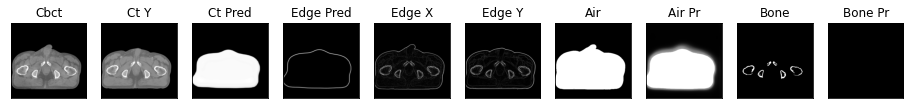

89it [00:40,  2.19it/s]

ssim score = 0.7735928297042847
psnr score = 18.428340911865234
snr score = 9.20895767211914
mae error = 0.05005766823887825
air dice score = 0.9816781731280015
bone dice score = 3.700962250048077e-11
contour dice score = 0.0349917970597744


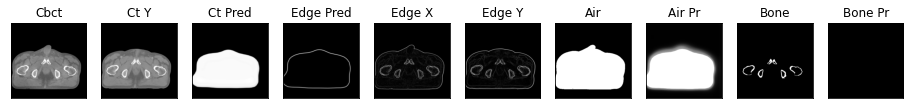

90it [00:41,  2.23it/s]

ssim score = 0.7692033648490906
psnr score = 18.33932113647461
snr score = 9.188529014587402
mae error = 0.051006197929382324
air dice score = 0.9824259670408844
bone dice score = 3.36134453770214e-11
contour dice score = 0.042810097336769104


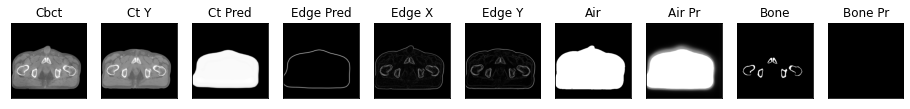

91it [00:41,  2.31it/s]

ssim score = 0.7617260217666626
psnr score = 18.24689483642578
snr score = 9.177462577819824
mae error = 0.05195504426956177
air dice score = 0.9815358201966743
bone dice score = 3.063725490102214e-11
contour dice score = 0.047304730862379074


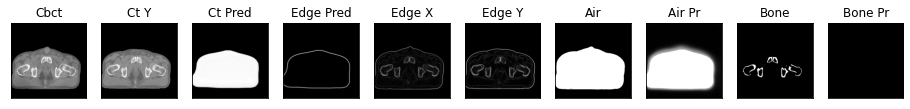

92it [00:41,  2.30it/s]

ssim score = 0.755978524684906
psnr score = 18.24896812438965
snr score = 9.230238914489746
mae error = 0.052530091255903244
air dice score = 0.9793272190317539
bone dice score = 2.908667830049195e-11
contour dice score = 0.048431482166051865


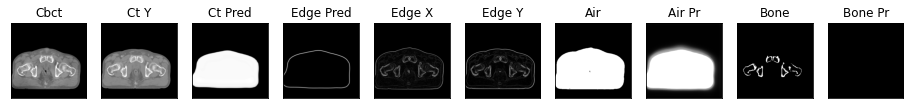

93it [00:42,  2.36it/s]

ssim score = 0.7518985271453857
psnr score = 18.0518856048584
snr score = 9.14942455291748
mae error = 0.05438753217458725
air dice score = 0.9792561583280126
bone dice score = 2.642007925953976e-11
contour dice score = 0.050632912665605545


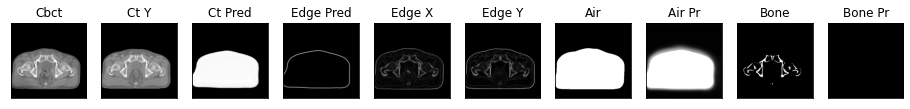

94it [00:42,  2.40it/s]

ssim score = 0.7520401477813721
psnr score = 18.17716407775879
snr score = 9.236468315124512
mae error = 0.053806718438863754
air dice score = 0.9736542628650026
bone dice score = 2.8677946658196788e-11
contour dice score = 0.05399449169635773


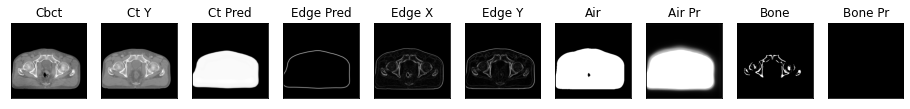

95it [00:43,  2.42it/s]

ssim score = 0.7567343711853027
psnr score = 18.189613342285156
snr score = 9.15324592590332
mae error = 0.05356018245220184
air dice score = 0.9703078350210314
bone dice score = 2.635046113237548e-11
contour dice score = 0.058370042592287064


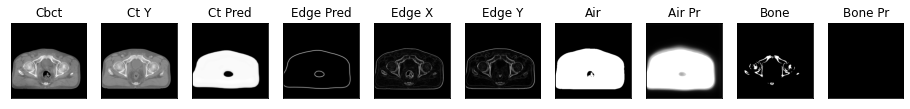

96it [00:43,  2.44it/s]

ssim score = 0.7628979086875916
psnr score = 18.275697708129883
snr score = 9.079570770263672
mae error = 0.05157911777496338
air dice score = 0.9669968803021439
bone dice score = 3.317850033068419e-11
contour dice score = 0.06504961103200912


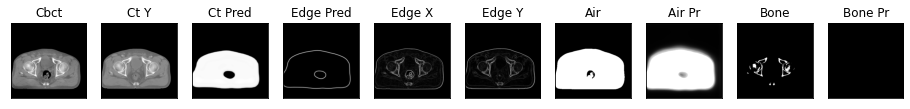

97it [00:44,  2.04it/s]

ssim score = 0.7683945298194885
psnr score = 18.3688907623291
snr score = 9.056340217590332
mae error = 0.0505838580429554
air dice score = 0.9684794232978425
bone dice score = 3.424657534129292e-11
contour dice score = 0.0653739646077156


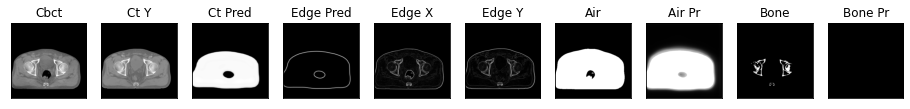

98it [00:44,  2.14it/s]

ssim score = 0.7693780660629272
psnr score = 18.281496047973633
snr score = 8.923849105834961
mae error = 0.05154251679778099
air dice score = 0.9702325358622744
bone dice score = 3.183699458669733e-11
contour dice score = 0.06869806349277496


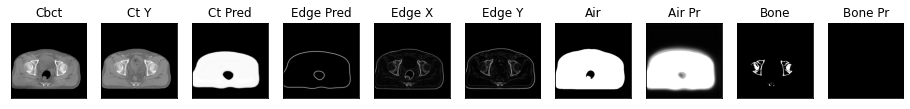

99it [00:45,  2.23it/s]

ssim score = 0.7741674780845642
psnr score = 18.156896591186523
snr score = 8.805924415588379
mae error = 0.05248142033815384
air dice score = 0.9746394908563807
bone dice score = 3.183699458669733e-11
contour dice score = 0.09682804346084595


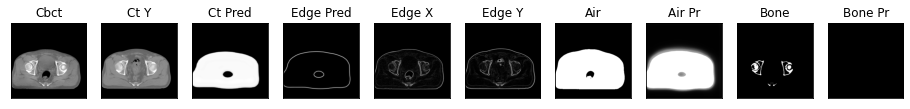

100it [00:45,  2.26it/s]

ssim score = 0.7735121846199036
psnr score = 17.937034606933594
snr score = 8.616167068481445
mae error = 0.05367143452167511
air dice score = 0.9781435400485515
bone dice score = 3.0012004801020045e-11
contour dice score = 0.06804239004850388


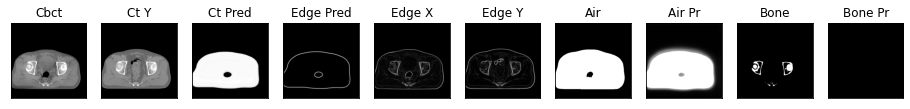

101it [00:45,  2.35it/s]

ssim score = 0.7723851203918457
psnr score = 17.523588180541992
snr score = 8.160133361816406
mae error = 0.05572502687573433
air dice score = 0.9814044170653538
bone dice score = 3.3333333332222224e-11
contour dice score = 0.06520577520132065


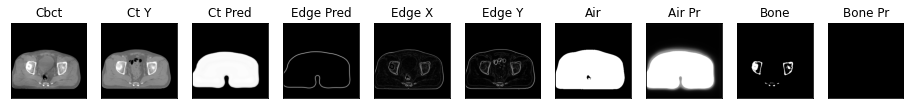

102it [00:46,  2.42it/s]

ssim score = 0.7738190293312073
psnr score = 18.143308639526367
snr score = 8.689648628234863
mae error = 0.05176524072885513
air dice score = 0.9742188488298763
bone dice score = 3.736920777139876e-11
contour dice score = 0.07058823853731155


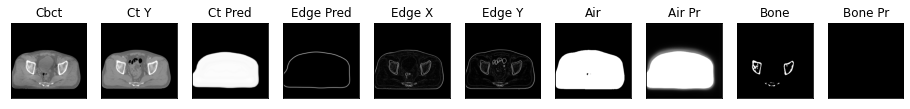

103it [00:46,  2.47it/s]

ssim score = 0.7762235999107361
psnr score = 18.333932876586914
snr score = 8.81454849243164
mae error = 0.05023562163114548
air dice score = 0.9819709229985704
bone dice score = 3.907776475032912e-11
contour dice score = 0.06390134245157242


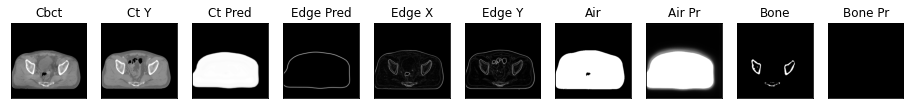

104it [00:47,  2.50it/s]

ssim score = 0.7758263945579529
psnr score = 18.403284072875977
snr score = 8.883596420288086
mae error = 0.0496426559984684
air dice score = 0.9804419694306044
bone dice score = 3.415300546331445e-11
contour dice score = 0.06400898098945618


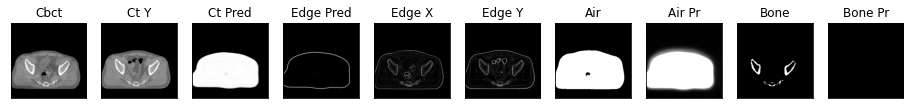

105it [00:47,  2.52it/s]

ssim score = 0.7700589299201965
psnr score = 18.339765548706055
snr score = 8.896245002746582
mae error = 0.05063356086611748
air dice score = 0.9782628992420633
bone dice score = 2.778549597033105e-11
contour dice score = 0.08225352317094803


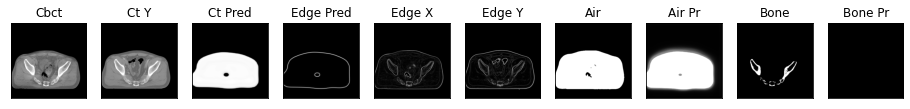

106it [00:47,  2.55it/s]

ssim score = 0.7691172361373901
psnr score = 18.30500030517578
snr score = 8.897061347961426
mae error = 0.05141691491007805
air dice score = 0.9781787985926411
bone dice score = 2.5906735750624178e-11
contour dice score = 0.041713640093803406


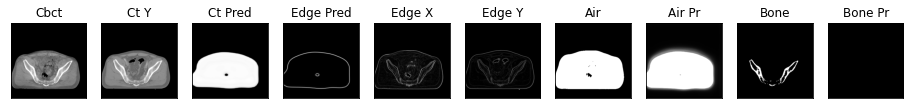

107it [00:48,  2.14it/s]

ssim score = 0.7677911520004272
psnr score = 18.271326065063477
snr score = 8.801689147949219
mae error = 0.051789235323667526
air dice score = 0.9693315167230965
bone dice score = 2.7639579877621902e-11
contour dice score = 0.02718006819486618


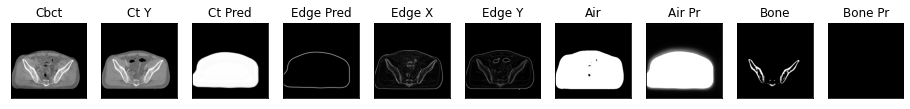

108it [00:48,  2.27it/s]

ssim score = 0.7680821418762207
psnr score = 18.409381866455078
snr score = 8.878485679626465
mae error = 0.05067596212029457
air dice score = 0.9692758773878549
bone dice score = 2.894356005704939e-11
contour dice score = 0.0023001725785434246


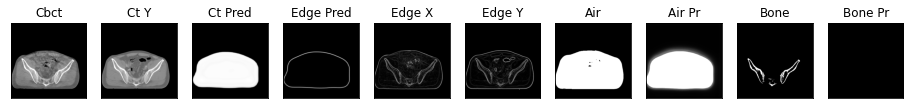

109it [00:49,  2.36it/s]

ssim score = 0.7329913973808289
psnr score = 15.444704055786133
snr score = 7.142010688781738
mae error = 0.0843253806233406
air dice score = 0.9746888413300167
bone dice score = 6.325110689036994e-11
contour dice score = 0.11084794253110886


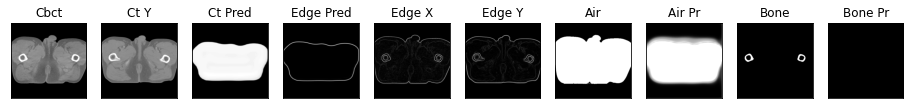

110it [00:49,  2.35it/s]

ssim score = 0.7246455550193787
psnr score = 15.418180465698242
snr score = 7.219777584075928
mae error = 0.08499947190284729
air dice score = 0.9733445516550168
bone dice score = 5.681818181495351e-11
contour dice score = 0.1054631844162941


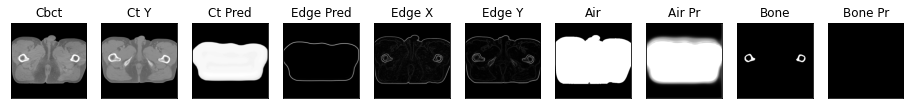

111it [00:50,  2.40it/s]

ssim score = 0.7180643081665039
psnr score = 15.376806259155273
snr score = 7.306360244750977
mae error = 0.08589965850114822
air dice score = 0.9665949250330274
bone dice score = 4.559963520083905e-11
contour dice score = 0.1009523794054985


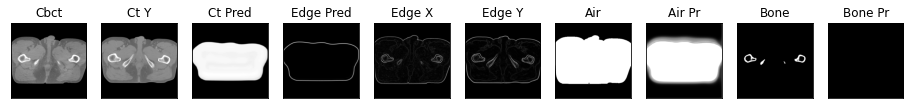

112it [00:50,  2.48it/s]

ssim score = 0.712527871131897
psnr score = 15.388679504394531
snr score = 7.350522994995117
mae error = 0.08615922182798386
air dice score = 0.9651263851669654
bone dice score = 3.344481605239315e-11
contour dice score = 0.09818875044584274


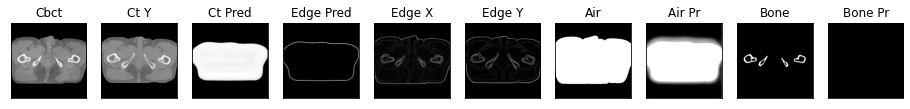

113it [00:50,  2.45it/s]

ssim score = 0.706537127494812
psnr score = 15.349609375
snr score = 7.341690540313721
mae error = 0.08706352114677429
air dice score = 0.9623301533981631
bone dice score = 3.231017770493343e-11
contour dice score = 0.0983763113617897


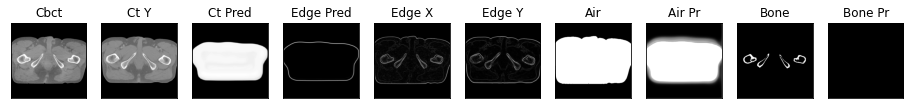

114it [00:51,  2.22it/s]

ssim score = 0.6986597180366516
psnr score = 15.290173530578613
snr score = 7.316670894622803
mae error = 0.0880843997001648
air dice score = 0.9666076837717262
bone dice score = 3.0684258974204225e-11
contour dice score = 0.0984233170747757


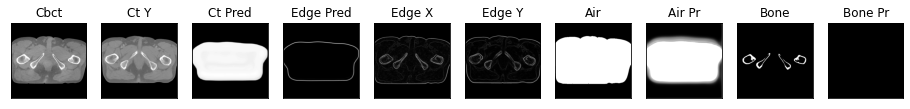

115it [00:52,  1.61it/s]

ssim score = 0.6957453489303589
psnr score = 15.26807975769043
snr score = 7.314887523651123
mae error = 0.08794594556093216
air dice score = 0.9726262117214759
bone dice score = 2.6874496102475827e-11
contour dice score = 0.10000000149011612


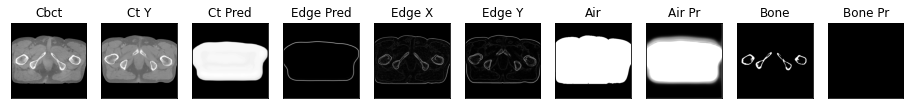

116it [00:53,  1.49it/s]

ssim score = 0.6922748684883118
psnr score = 15.172266960144043
snr score = 7.258148193359375
mae error = 0.08860066533088684
air dice score = 0.9746113806168487
bone dice score = 2.6659557450635575e-11
contour dice score = 0.12387707084417343


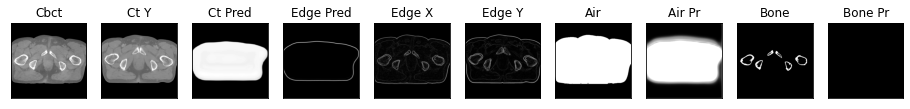

117it [00:54,  1.30it/s]

ssim score = 0.6879141926765442
psnr score = 15.042529106140137
snr score = 7.177090644836426
mae error = 0.08985982090234756
air dice score = 0.9757772425043871
bone dice score = 2.57731958756244e-11
contour dice score = 0.10516689717769623


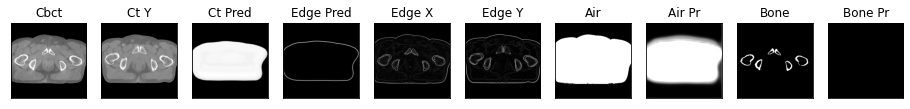

118it [00:54,  1.48it/s]

ssim score = 0.678846001625061
psnr score = 15.091909408569336
snr score = 7.249081611633301
mae error = 0.08986372500658035
air dice score = 0.9780179165420146
bone dice score = 2.4801587300972182e-11
contour dice score = 0.10102815926074982


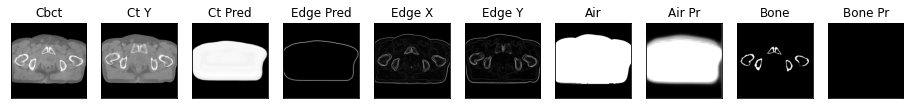

119it [00:55,  1.66it/s]

ssim score = 0.6668177247047424
psnr score = 15.080617904663086
snr score = 7.280567169189453
mae error = 0.0911639928817749
air dice score = 0.9786541646912968
bone dice score = 2.3110700253683597e-11
contour dice score = 0.10290827602148056


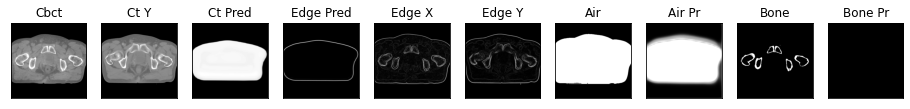

120it [00:55,  1.80it/s]

ssim score = 0.6668155193328857
psnr score = 15.030089378356934
snr score = 7.288378715515137
mae error = 0.09272854030132294
air dice score = 0.977404860263068
bone dice score = 2.1083702297679026e-11
contour dice score = 0.11015325784683228


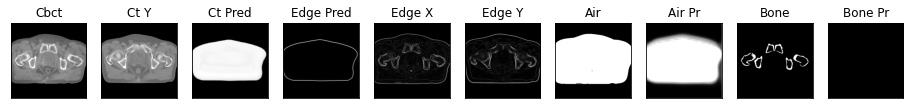

121it [00:55,  1.93it/s]

ssim score = 0.6691024303436279
psnr score = 14.9926176071167
snr score = 7.175535678863525
mae error = 0.0926906019449234
air dice score = 0.9746863641693195
bone dice score = 1.9051247856371665e-11
contour dice score = 0.11164581030607224


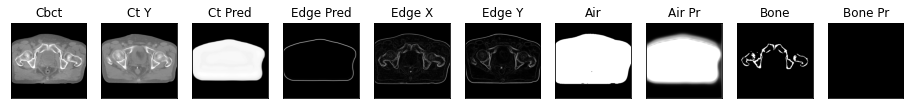

122it [00:56,  2.04it/s]

ssim score = 0.6694411635398865
psnr score = 14.78094482421875
snr score = 6.856644153594971
mae error = 0.09458912909030914
air dice score = 0.9695553667516464
bone dice score = 1.8545994064937944e-11
contour dice score = 0.11555127799510956


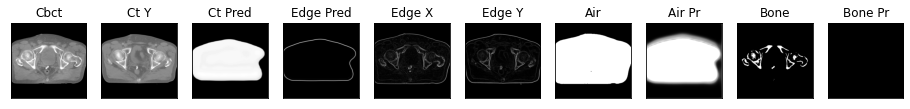

123it [00:56,  2.11it/s]

ssim score = 0.6778256893157959
psnr score = 15.05553150177002
snr score = 7.008141994476318
mae error = 0.09262767434120178
air dice score = 0.97572134984369
bone dice score = 1.9391118867182643e-11
contour dice score = 0.10852713137865067


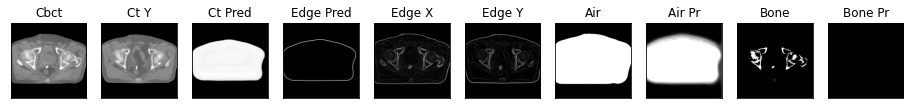

124it [00:57,  2.15it/s]

ssim score = 0.689905047416687
psnr score = 15.1340970993042
snr score = 6.974277973175049
mae error = 0.09206949174404144
air dice score = 0.9762716647461513
bone dice score = 2.0395676116247285e-11
contour dice score = 0.10710807889699936


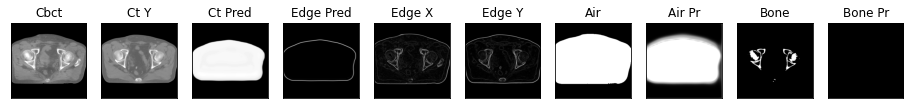

125it [00:57,  2.20it/s]

ssim score = 0.6977530121803284
psnr score = 15.249849319458008
snr score = 7.039384365081787
mae error = 0.09091385453939438
air dice score = 0.9775915145593483
bone dice score = 2.0104543626455478e-11
contour dice score = 0.10469667613506317


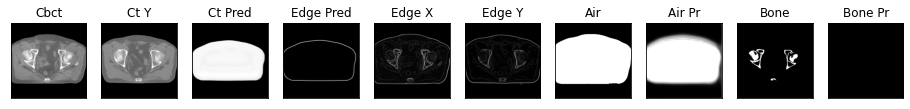

126it [00:58,  2.23it/s]

ssim score = 0.7007362246513367
psnr score = 15.343515396118164
snr score = 7.165205001831055
mae error = 0.08977959305047989
air dice score = 0.9780401416765183
bone dice score = 2.1263023601504083e-11
contour dice score = 0.10304220020771027


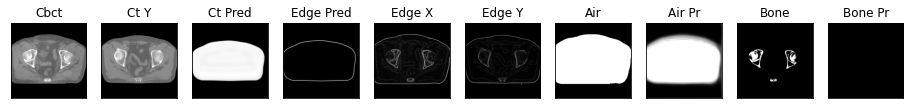

127it [00:58,  1.91it/s]

ssim score = 0.6998968124389648
psnr score = 15.354007720947266
snr score = 7.189173698425293
mae error = 0.08895200490951538
air dice score = 0.977877076431662
bone dice score = 2.2983222247230908e-11
contour dice score = 0.10236220806837082


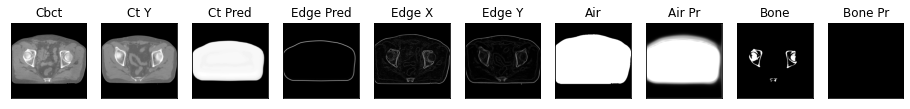

128it [00:59,  2.02it/s]

ssim score = 0.7069494128227234
psnr score = 15.635137557983398
snr score = 7.328812599182129
mae error = 0.08561061322689056
air dice score = 0.9793012462040522
bone dice score = 2.2810218977581884e-11
contour dice score = 0.10084033757448196


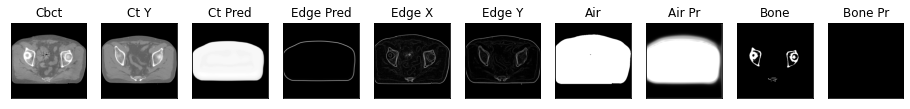

129it [00:59,  2.10it/s]

ssim score = 0.7114851474761963
psnr score = 15.761308670043945
snr score = 7.395675182342529
mae error = 0.08385663479566574
air dice score = 0.9803825609501475
bone dice score = 2.6745119015064317e-11
contour dice score = 0.0932539701461792


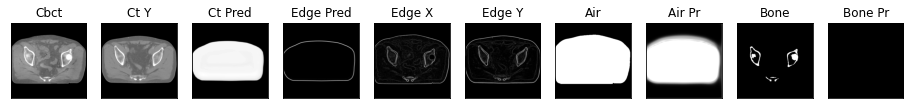

130it [01:00,  2.17it/s]

ssim score = 0.7103163599967957
psnr score = 15.811004638671875
snr score = 7.471018314361572
mae error = 0.08165500313043594
air dice score = 0.9807511314929828
bone dice score = 3.707823507463559e-11
contour dice score = 0.0854446068406105


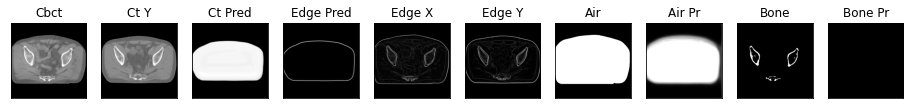

131it [01:00,  2.21it/s]

ssim score = 0.7071977257728577
psnr score = 15.625848770141602
snr score = 7.358675956726074
mae error = 0.08309746533632278
air dice score = 0.9775333248622063
bone dice score = 3.449465332754417e-11
contour dice score = 0.07737512141466141


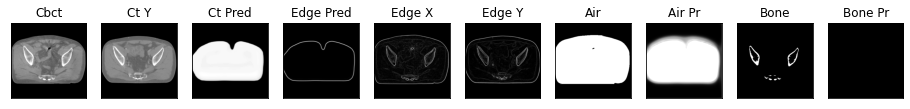

132it [01:00,  2.24it/s]

ssim score = 0.694844663143158
psnr score = 15.305933952331543
snr score = 7.167991638183594
mae error = 0.08714300394058228
air dice score = 0.9748861925859269
bone dice score = 3.211303789235347e-11
contour dice score = 0.07421686500310898


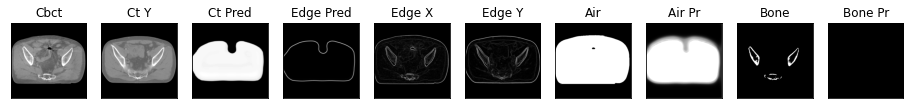

133it [01:01,  2.29it/s]

ssim score = 0.6863594055175781
psnr score = 15.235329627990723
snr score = 7.131347179412842
mae error = 0.08761528134346008
air dice score = 0.9736319749062823
bone dice score = 2.913752913668014e-11
contour dice score = 0.06740491092205048


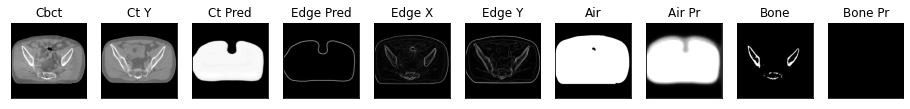

134it [01:01,  2.33it/s]

ssim score = 0.7013251185417175
psnr score = 15.907455444335938
snr score = 7.773683071136475
mae error = 0.0791945606470108
air dice score = 0.9834290322385155
bone dice score = 2.358490565982111e-11
contour dice score = 0.06467913091182709


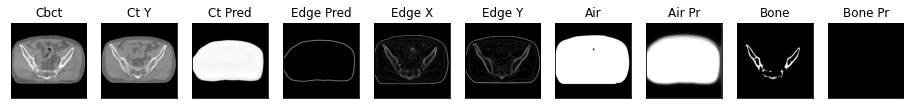

135it [01:02,  2.34it/s]

ssim score = 0.7027860283851624
psnr score = 15.958961486816406
snr score = 7.761812210083008
mae error = 0.07747825235128403
air dice score = 0.9839313952074055
bone dice score = 2.581311306076889e-11
contour dice score = 0.06294415891170502


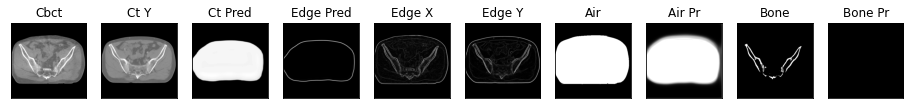

136it [01:02,  2.34it/s]

ssim score = 0.7347431778907776
psnr score = 16.685007095336914
snr score = 8.162399291992188
mae error = 0.06596781313419342
air dice score = 0.9713406600102273
bone dice score = 2.3546032492970425e-11
contour dice score = 5.221932261600948e-11


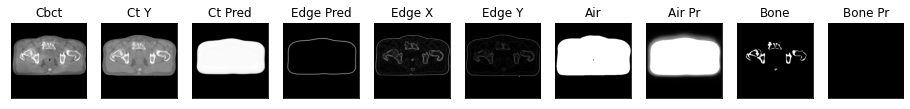

137it [01:03,  1.91it/s]

ssim score = 0.7289860248565674
psnr score = 16.664649963378906
snr score = 8.182053565979004
mae error = 0.06641450524330139
air dice score = 0.9755556058992958
bone dice score = 2.4479804160967446e-11
contour dice score = 5.23560222953634e-11


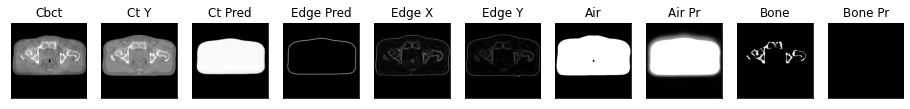

138it [01:03,  2.03it/s]

ssim score = 0.7287888526916504
psnr score = 16.67284393310547
snr score = 8.198034286499023
mae error = 0.06637942790985107
air dice score = 0.9788558146509868
bone dice score = 2.5484199795476957e-11
contour dice score = 5.2521008375716605e-11


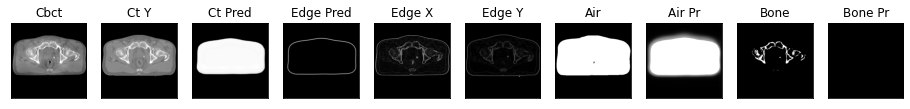

139it [01:04,  2.11it/s]

ssim score = 0.7347115278244019
psnr score = 16.745010375976562
snr score = 8.21178150177002
mae error = 0.0651470199227333
air dice score = 0.9790791858409876
bone dice score = 2.427184465960505e-11
contour dice score = 5.265929359232757e-11


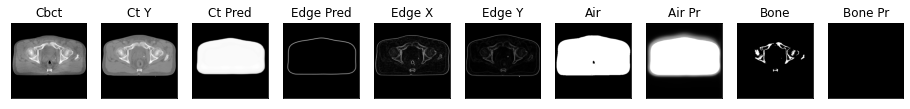

140it [01:04,  2.20it/s]

ssim score = 0.7432562708854675
psnr score = 16.77119255065918
snr score = 8.0823392868042
mae error = 0.06309951841831207
air dice score = 0.9773320347640069
bone dice score = 2.960331557046764e-11
contour dice score = 5.2826201746292156e-11


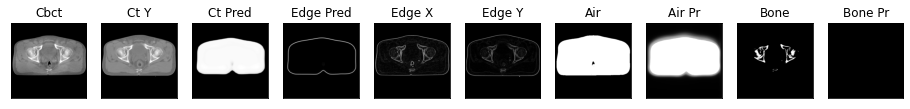

141it [01:05,  2.24it/s]

ssim score = 0.7469441294670105
psnr score = 16.835247039794922
snr score = 8.125589370727539
mae error = 0.062138695269823074
air dice score = 0.9774914830628413
bone dice score = 2.7601435273872442e-11
contour dice score = 5.302227060188791e-11


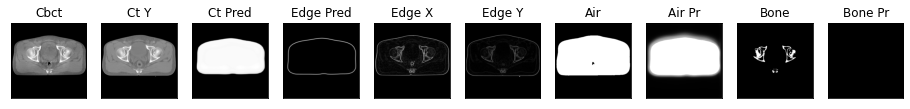

142it [01:05,  2.25it/s]

ssim score = 0.7526463866233826
psnr score = 16.823644638061523
snr score = 8.098356246948242
mae error = 0.06225903704762459
air dice score = 0.9796020276916247
bone dice score = 2.7352297592249663e-11
contour dice score = 5.3248138537353995e-11


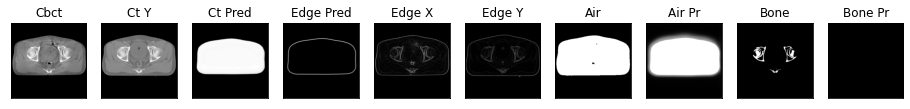

143it [01:05,  2.26it/s]

ssim score = 0.752643883228302
psnr score = 16.54245948791504
snr score = 7.826536178588867
mae error = 0.06512228399515152
air dice score = 0.9664787527701361
bone dice score = 2.7210884353001064e-11
contour dice score = 5.327650473563317e-11


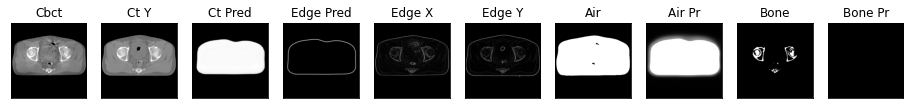

144it [01:06,  2.27it/s]

ssim score = 0.75346440076828
psnr score = 16.372440338134766
snr score = 7.712297439575195
mae error = 0.06679382920265198
air dice score = 0.9557812660306084
bone dice score = 2.6666666665955555e-11
contour dice score = 5.3418804102367545e-11


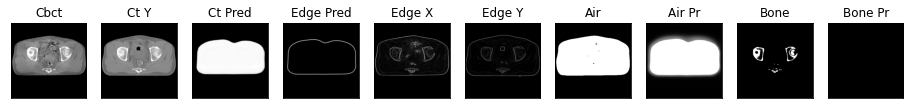

145it [01:06,  2.27it/s]

ssim score = 0.7518458366394043
psnr score = 16.321828842163086
snr score = 7.639756679534912
mae error = 0.06709147989749908
air dice score = 0.9391009138885803
bone dice score = 2.7389756230419344e-11
contour dice score = 5.173305880901147e-11


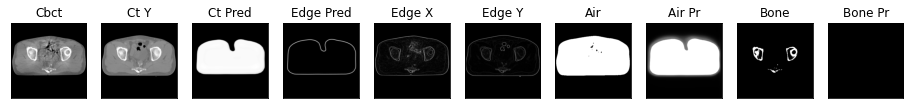

146it [01:07,  2.30it/s]

ssim score = 0.7538431286811829
psnr score = 16.44005012512207
snr score = 7.687204360961914
mae error = 0.06557968258857727
air dice score = 0.9362043015973717
bone dice score = 3.041362530321127e-11
contour dice score = 5.189413829209677e-11


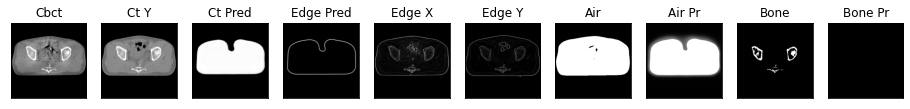

147it [01:07,  1.96it/s]

ssim score = 0.7521224617958069
psnr score = 16.471120834350586
snr score = 7.674379825592041
mae error = 0.06525664776563644
air dice score = 0.9513179881193574
bone dice score = 3.231017770493343e-11
contour dice score = 5.387931073519425e-11


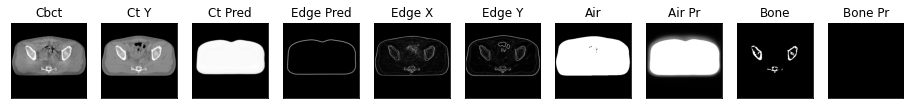

148it [01:08,  2.05it/s]

ssim score = 0.7540364861488342
psnr score = 16.526851654052734
snr score = 7.729014873504639
mae error = 0.06433714926242828
air dice score = 0.944102286761368
bone dice score = 3.127932436561528e-11
contour dice score = 5.393743437998033e-11


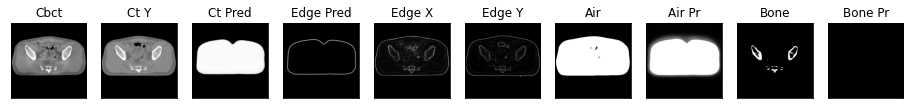

149it [01:08,  2.10it/s]

ssim score = 0.7461097240447998
psnr score = 16.25989532470703
snr score = 7.475416660308838
mae error = 0.06704983860254288
air dice score = 0.9259445263167171
bone dice score = 2.999400119886041e-11
contour dice score = 5.327650473563317e-11


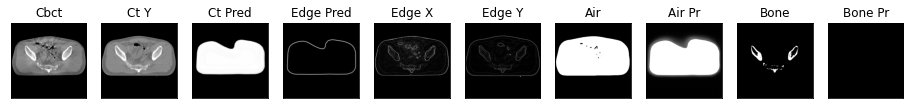

150it [01:09,  2.18it/s]

ssim score = 0.737979531288147
psnr score = 16.101442337036133
snr score = 7.37216854095459
mae error = 0.06874016672372818
air dice score = 0.9259446177266909
bone dice score = 2.501250625250094e-11
contour dice score = 5.333333427670617e-11


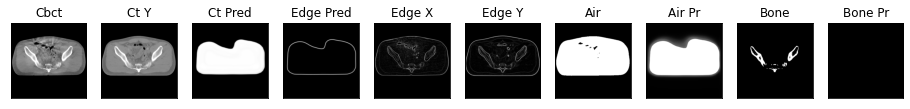

151it [01:09,  2.19it/s]

ssim score = 0.7359790802001953
psnr score = 16.18252944946289
snr score = 7.472623825073242
mae error = 0.06841176748275757
air dice score = 0.928238922467668
bone dice score = 2.5595085742882133e-11
contour dice score = 5.3533191768373456e-11


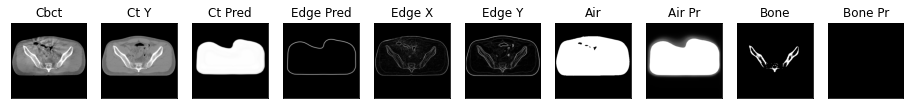

152it [01:10,  2.21it/s]

ssim score = 0.7368507385253906
psnr score = 16.31906509399414
snr score = 7.554421424865723
mae error = 0.06784966588020325
air dice score = 0.9393971634108312
bone dice score = 2.8042624788893925e-11
contour dice score = 5.390835694507601e-11


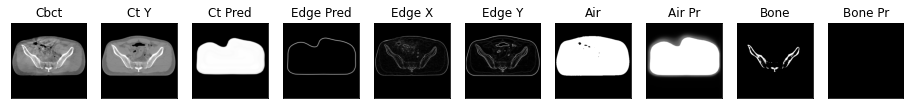

153it [01:10,  2.25it/s]

ssim score = 0.7320722937583923
psnr score = 16.284324645996094
snr score = 7.483327865600586
mae error = 0.06804412603378296
air dice score = 0.9467429649017713
bone dice score = 2.801120448100809e-11
contour dice score = 5.467468491837657e-11


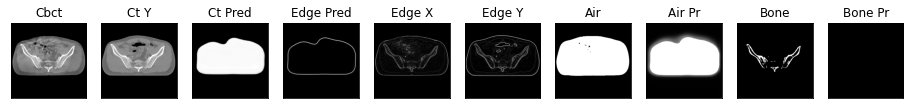

154it [01:11,  2.28it/s]

ssim score = 0.7384634017944336
psnr score = 16.69873809814453
snr score = 7.897812843322754
mae error = 0.06402947008609772
air dice score = 0.9789142618415307
bone dice score = 2.5252525251887564e-11
contour dice score = 5.515719825321952e-11


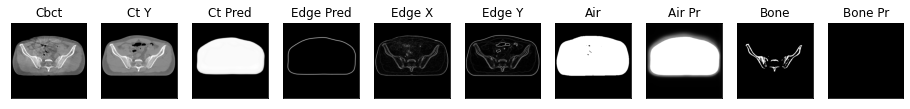

155it [01:11,  2.27it/s]

ssim score = 0.73019939661026
psnr score = 16.451974868774414
snr score = 7.64962911605835
mae error = 0.06678136438131332
air dice score = 0.9627443274328774
bone dice score = 2.552322613513213e-11
contour dice score = 5.53709855743989e-11


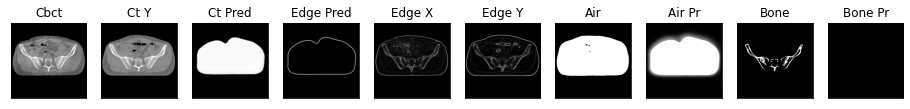

156it [01:11,  2.28it/s]

ssim score = 0.7192257046699524
psnr score = 15.922093391418457
snr score = 7.124785900115967
mae error = 0.07191252708435059
air dice score = 0.9284674689577188
bone dice score = 2.570033410368285e-11
contour dice score = 0.0022026430815458298


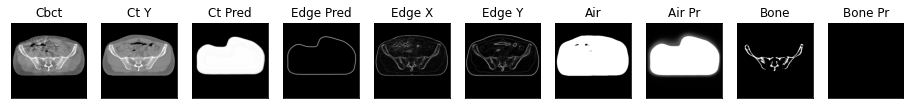

157it [01:12,  1.94it/s]

ssim score = 0.7206813097000122
psnr score = 15.947059631347656
snr score = 7.132479667663574
mae error = 0.07179950177669525
air dice score = 0.9297078246948755
bone dice score = 2.5753283542988583e-11
contour dice score = 0.0044052861630916595


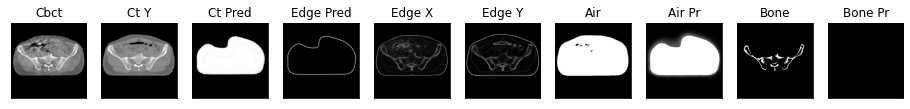

158it [01:13,  2.03it/s]

ssim score = 0.7199931144714355
psnr score = 15.962252616882324
snr score = 7.129049777984619
mae error = 0.07216518372297287
air dice score = 0.9341372217550077
bone dice score = 2.3992322456238187e-11
contour dice score = 5.5865922998776796e-11


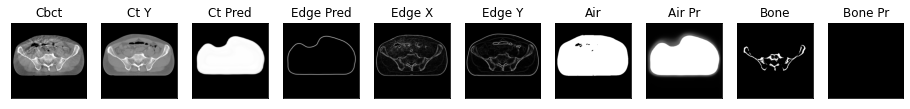

159it [01:13,  2.12it/s]

ssim score = 0.7137789130210876
psnr score = 15.817402839660645
snr score = 6.93826150894165
mae error = 0.0745212510228157
air dice score = 0.9235479164383167
bone dice score = 2.3137436371514637e-11
contour dice score = 5.6338027992763884e-11


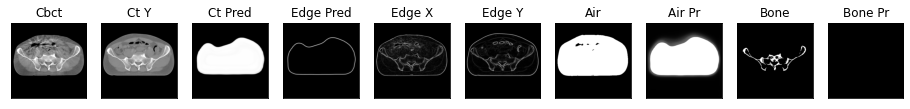

160it [01:13,  2.18it/s]

ssim score = 0.7102617025375366
psnr score = 15.72524642944336
snr score = 6.792307376861572
mae error = 0.0766712874174118
air dice score = 0.9154356230318959
bone dice score = 2.277385561323676e-11
contour dice score = 5.6211355015101105e-11


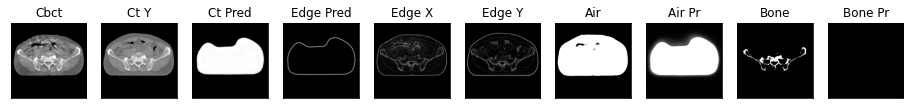

161it [01:14,  2.22it/s]

ssim score = 0.7127645611763
psnr score = 15.899039268493652
snr score = 6.996563911437988
mae error = 0.07480251789093018
air dice score = 0.9283210729458474
bone dice score = 2.228660574944759e-11
contour dice score = 5.627462038026998e-11


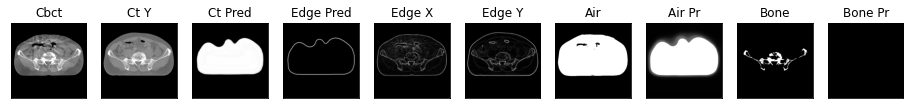

162it [01:14,  2.25it/s]

ssim score = 0.7154272794723511
psnr score = 16.090404510498047
snr score = 7.132702350616455
mae error = 0.07257328182458878
air dice score = 0.9560369178217533
bone dice score = 2.3148148147612312e-11
contour dice score = 5.59910416642051e-11


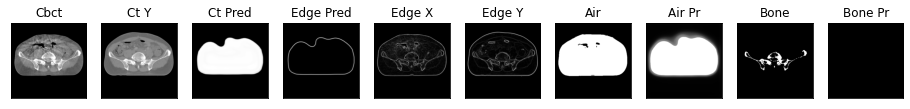

163it [01:15,  2.28it/s]

ssim score = 0.7270930409431458
psnr score = 16.61424446105957
snr score = 7.509012222290039
mae error = 0.06700211763381958
air dice score = 0.9727030364038373
bone dice score = 2.4425989251968098e-11
contour dice score = 5.6053810898459844e-11


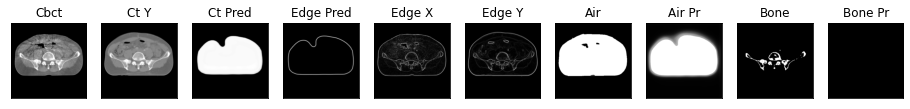

164it [01:15,  2.31it/s]

ssim score = 0.7509490251541138
psnr score = 17.804162979125977
snr score = 8.185073852539062
mae error = 0.06017785519361496
air dice score = 0.9813859873360209
bone dice score = 5.515719801129855e-11
contour dice score = 5.025125801583208e-11


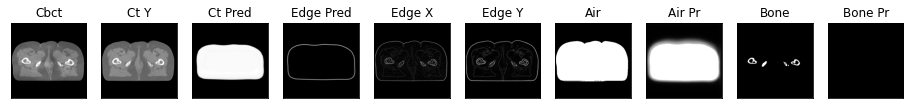

165it [01:16,  2.32it/s]

ssim score = 0.7452090382575989
psnr score = 17.71094512939453
snr score = 8.212867736816406
mae error = 0.06090070679783821
air dice score = 0.9803252388244875
bone dice score = 4.6554934820923885e-11
contour dice score = 5.136106817626995e-11


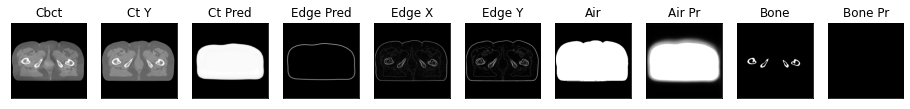

166it [01:16,  2.34it/s]

ssim score = 0.7395135164260864
psnr score = 17.688640594482422
snr score = 8.273480415344238
mae error = 0.061065904796123505
air dice score = 0.9798763855841363
bone dice score = 4.1666666664930555e-11
contour dice score = 5.070993971956206e-11


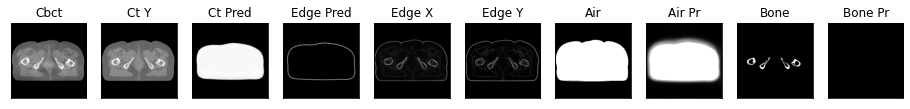

167it [01:17,  1.94it/s]

ssim score = 0.7355886101722717
psnr score = 17.618078231811523
snr score = 8.266364097595215
mae error = 0.06184934452176094
air dice score = 0.9803153022852327
bone dice score = 3.703703703566529e-11
contour dice score = 5.070993971956206e-11


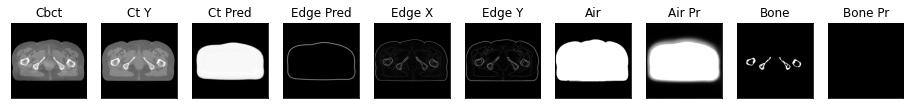

168it [01:17,  2.04it/s]

ssim score = 0.7331288456916809
psnr score = 17.524066925048828
snr score = 8.200813293457031
mae error = 0.06283209472894669
air dice score = 0.9813049060196607
bone dice score = 3.527336860545773e-11
contour dice score = 5.1072524681616827e-11


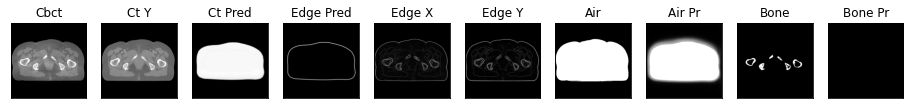

169it [01:18,  2.11it/s]

ssim score = 0.733207106590271
psnr score = 17.471006393432617
snr score = 8.170709609985352
mae error = 0.06326969712972641
air dice score = 0.9816505820747092
bone dice score = 3.688675765264158e-11
contour dice score = 5.0632911058334784e-11


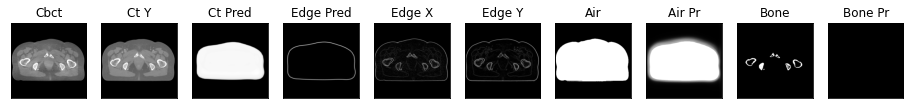

170it [01:18,  2.19it/s]

ssim score = 0.7302135825157166
psnr score = 17.45659828186035
snr score = 8.187628746032715
mae error = 0.06335298717021942
air dice score = 0.9824200041771521
bone dice score = 3.631082062322764e-11
contour dice score = 5.025125801583208e-11


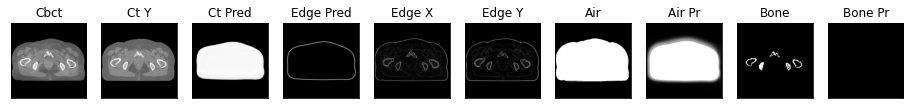

171it [01:18,  2.23it/s]

ssim score = 0.7274561524391174
psnr score = 17.423030853271484
snr score = 8.202425956726074
mae error = 0.06363175064325333
air dice score = 0.9827839566645661
bone dice score = 3.547357218746103e-11
contour dice score = 4.8804293939497256e-11


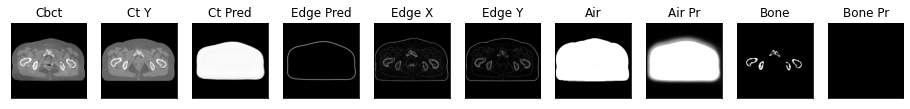

172it [01:19,  2.28it/s]

ssim score = 0.7254460453987122
psnr score = 17.411575317382812
snr score = 8.233713150024414
mae error = 0.06369100511074066
air dice score = 0.9815356098952153
bone dice score = 3.3090668430407324e-11
contour dice score = 4.985045015670764e-11


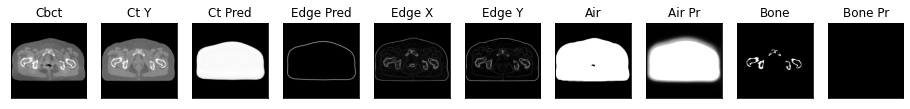

173it [01:19,  2.29it/s]

ssim score = 0.7204703688621521
psnr score = 17.373220443725586
snr score = 8.283060073852539
mae error = 0.06440955400466919
air dice score = 0.9802112696107883
bone dice score = 2.8352707682779906e-11
contour dice score = 4.840271239370253e-11


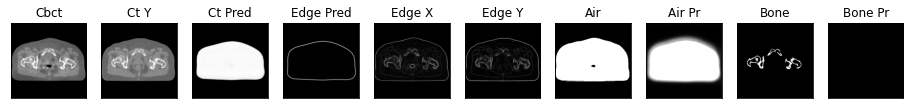

174it [01:20,  2.30it/s]

ssim score = 0.7187427282333374
psnr score = 17.18169403076172
snr score = 8.204805374145508
mae error = 0.06600943207740784
air dice score = 0.9839445447860934
bone dice score = 2.341372043962974e-11
contour dice score = 4.7801148456150244e-11


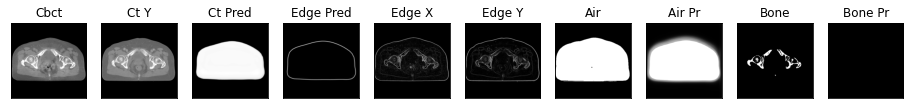

175it [01:20,  2.30it/s]

ssim score = 0.7196953892707825
psnr score = 17.157878875732422
snr score = 8.052440643310547
mae error = 0.06539491564035416
air dice score = 0.98170710099014
bone dice score = 3.394433129552124e-11
contour dice score = 4.7755494003709487e-11


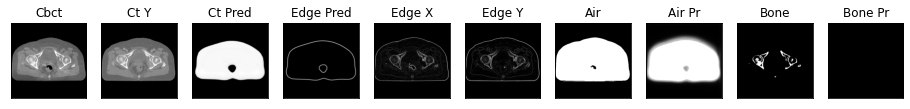

176it [01:20,  2.33it/s]

ssim score = 0.7234230041503906
psnr score = 16.97787857055664
snr score = 7.763016700744629
mae error = 0.06656698882579803
air dice score = 0.982450404088521
bone dice score = 3.8654812522665065e-11
contour dice score = 4.5413259958104746e-11


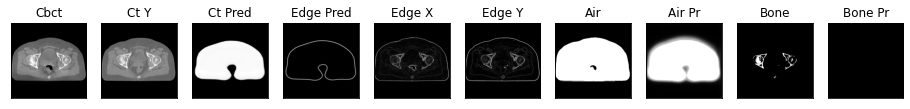

177it [01:21,  1.93it/s]

ssim score = 0.7278881072998047
psnr score = 16.820510864257812
snr score = 7.578523635864258
mae error = 0.06867965310811996
air dice score = 0.9833532603697349
bone dice score = 3.427004797689273e-11
contour dice score = 4.488330540564078e-11


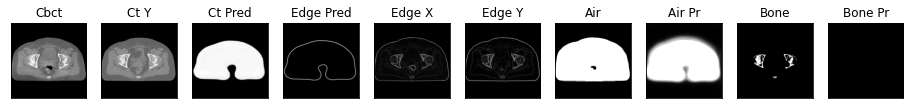

178it [01:22,  2.03it/s]

ssim score = 0.7379299402236938
psnr score = 17.36862564086914
snr score = 8.118633270263672
mae error = 0.0651422068476677
air dice score = 0.9863731508927789
bone dice score = 3.3222591361022506e-11
contour dice score = 0.0135790491476655


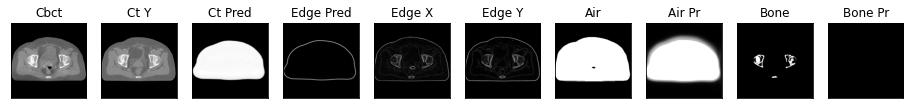

179it [01:22,  2.09it/s]

ssim score = 0.736717939376831
psnr score = 17.15347671508789
snr score = 7.9377121925354
mae error = 0.06748659163713455
air dice score = 0.9887975893193532
bone dice score = 3.164556961925172e-11
contour dice score = 0.03520782291889191


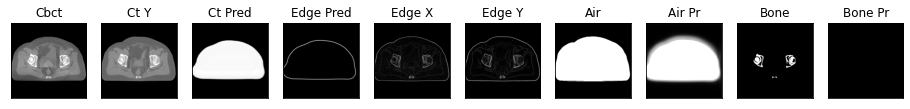

180it [01:23,  2.16it/s]

ssim score = 0.7319312691688538
psnr score = 16.888887405395508
snr score = 7.724615097045898
mae error = 0.06982307881116867
air dice score = 0.9888568976495744
bone dice score = 3.162555344618515e-11
contour dice score = 0.04597701132297516


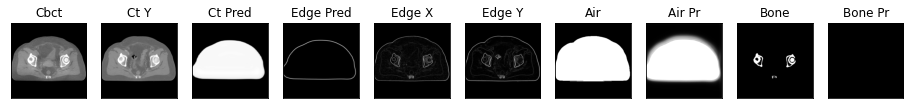

181it [01:23,  2.23it/s]

ssim score = 0.7174926400184631
psnr score = 16.678062438964844
snr score = 7.551348686218262
mae error = 0.07163703441619873
air dice score = 0.9879832094159045
bone dice score = 3.448275861950059e-11
contour dice score = 0.046277664601802826


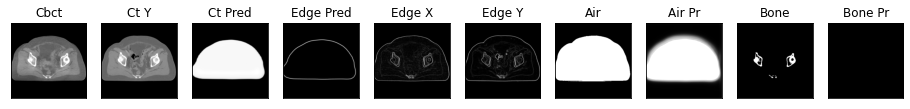

182it [01:23,  2.34it/s]

ssim score = 0.7095011472702026
psnr score = 16.662160873413086
snr score = 7.463009834289551
mae error = 0.07260821014642715
air dice score = 0.9859565214445978
bone dice score = 4.456327985541162e-11
contour dice score = 0.049822062253952026


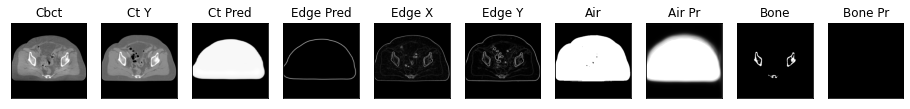

183it [01:24,  2.42it/s]

ssim score = 0.7021086812019348
psnr score = 16.28068733215332
snr score = 7.063545227050781
mae error = 0.07680436968803406
air dice score = 0.9849010419836333
bone dice score = 4.468275245555484e-11
contour dice score = 0.055413033813238144


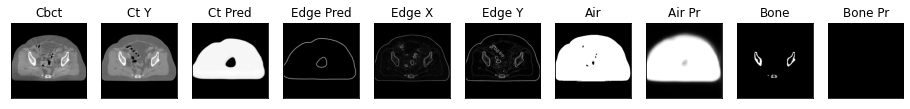

184it [01:24,  2.49it/s]

ssim score = 0.7069385051727295
psnr score = 16.4691219329834
snr score = 7.316892623901367
mae error = 0.07511799782514572
air dice score = 0.9813363496808722
bone dice score = 4.2863266179045725e-11
contour dice score = 0.05402650311589241


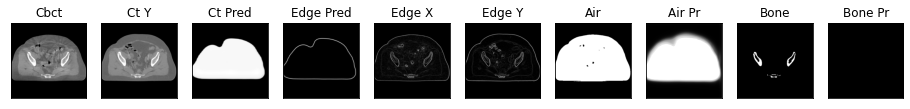

185it [01:24,  2.53it/s]

ssim score = 0.6998026967048645
psnr score = 16.357444763183594
snr score = 7.260309219360352
mae error = 0.07697662711143494
air dice score = 0.980497817119413
bone dice score = 3.6656891494257445e-11
contour dice score = 0.05344295874238014


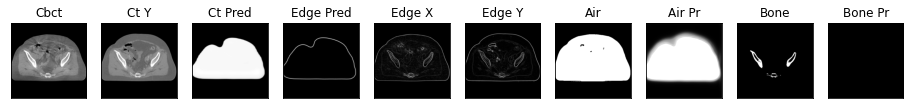

186it [01:25,  2.58it/s]

ssim score = 0.6851739883422852
psnr score = 16.050230026245117
snr score = 7.017525672912598
mae error = 0.0808134377002716
air dice score = 0.9818383049084702
bone dice score = 3.059975520102204e-11
contour dice score = 0.051203276962041855


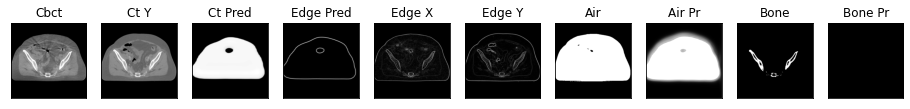

187it [01:25,  2.22it/s]

ssim score = 0.6803354024887085
psnr score = 15.948335647583008
snr score = 6.988489627838135
mae error = 0.08246622234582901
air dice score = 0.9806261480923624
bone dice score = 2.839295854547436e-11
contour dice score = 0.05308831110596657


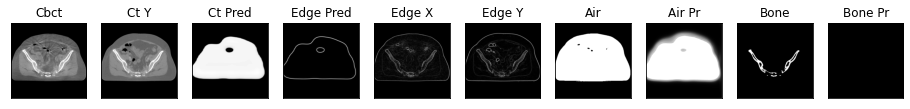

188it [01:26,  2.34it/s]

ssim score = 0.6731026768684387
psnr score = 15.900788307189941
snr score = 6.936652183532715
mae error = 0.08360911905765533
air dice score = 0.9792198562893302
bone dice score = 2.908667830049195e-11
contour dice score = 0.05175038054585457


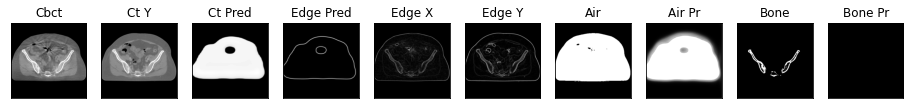

189it [01:26,  2.40it/s]

ssim score = 0.6699592471122742
psnr score = 15.936189651489258
snr score = 6.9498772621154785
mae error = 0.08386044204235077
air dice score = 0.9775123439812597
bone dice score = 2.8145229382827323e-11
contour dice score = 0.048411495983600616


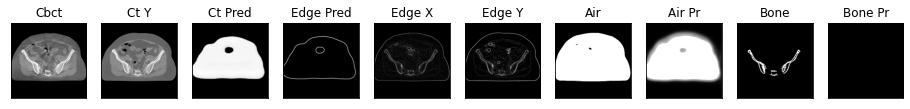

190it [01:27,  2.43it/s]

ssim score = 0.6761425733566284
psnr score = 16.173723220825195
snr score = 7.199046611785889
mae error = 0.08174273371696472
air dice score = 0.9842041156484491
bone dice score = 2.935995302321315e-11
contour dice score = 0.04321607947349548


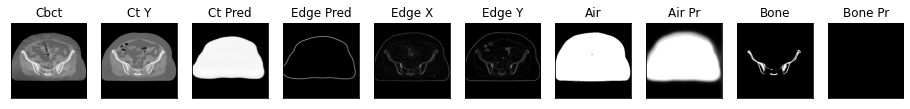

191it [01:27,  2.18it/s]


In [42]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [43]:
discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator)

In [44]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [45]:
# score_ssim, score_psnr, score_snr, score_mae, score_air, score_bone, score_cont, score_acc
# unmasked
eval_epoch(model, discriminator, testloader, device)

191it [00:14, 13.32it/s]


(0.7478951930375624,
 17.24685640484875,
 8.251128431390093,
 0.06411027126209275,
 0.9712310550694789,
 2.9564617685948747e-11,
 0.05087849511846812,
 0.5)

In [46]:
# import torchvision.models as models
# models.vgg16(pretrained=True)